##### Author  : SIVA VIKNESH & YOUNES TATARI
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com , younes.tatari@utah.edu/ younes.tatari@gmail.com
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA

In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


Combustion:  <br>
Paper: Symbolic regression via neural networks :
\
Chemical kinetics with Arrhenius rate dependence


$$
\dot{\alpha} = -k \alpha  e^{\theta} + \mu
$$

$$
\dot{\theta} = \alpha e^{\theta} - \theta
$$

Parameters: \\(k\\), \\(\mu\\)

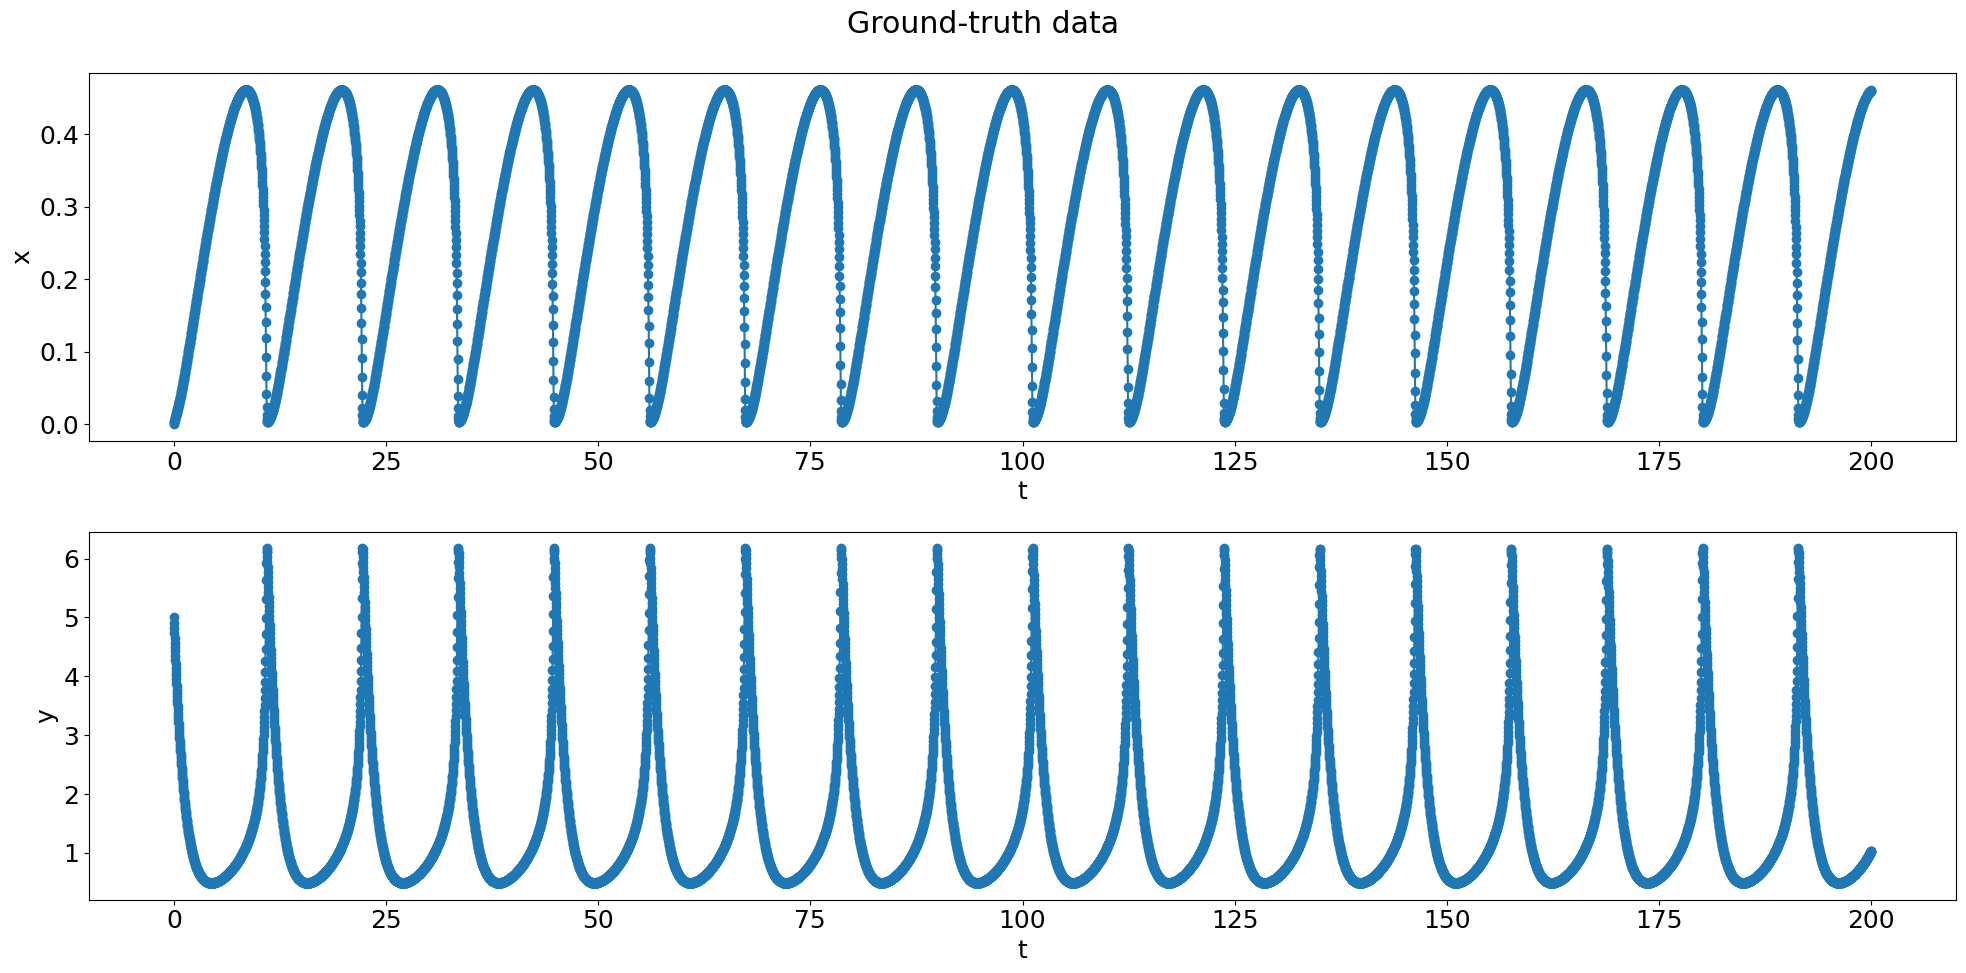

In [2]:
k  = 0.07
mu = 0.1
a  = 1.015
b  = 1.025

def oscillator_deriv(x_y, t0, a =a, b =b,  k=k, mu =mu):
    x, y = x_y
    dxdt = -k*x*np.exp(a*y) + mu
    dydt = x*np.exp(b*y) - y
    return [dxdt, dydt]

np.random.seed(123)
x0 = (0.0,5.0)

# Time points
t = np.linspace(0, 200, 10000)

x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o')
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o')
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

fig.tight_layout()
plt.show()

In [3]:
# COMPUTING THE COMBINATIONS AMONG THE THREE CHOSEN TEMPORAL MODES

def POOL_DATA(yin, nVars, polyorder):
    n = yin.shape[0]
    yout = torch.zeros((n, 1)).to(processor)

    # poly order 0
    yout[:, 0] = torch.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = torch.cat((yout, yin[:, i].reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i, nVars):
                yout = torch.cat((yout, (yin[:, i] * yin[:, j]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    yout = torch.cat((yout, (yin[:, i] * yin[:, j] * yin[:, k]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    return yout

def DERIVATIVE(x, y, k, a, b, mu):
    dxdt = -k*torch.mul(x,torch.exp(a*y)) + mu
    dydt = torch.mul(x, torch.exp(b*y)) - y
    return torch.vstack((dxdt, dydt)).T


AVAILABLE PROCESSOR: cuda 



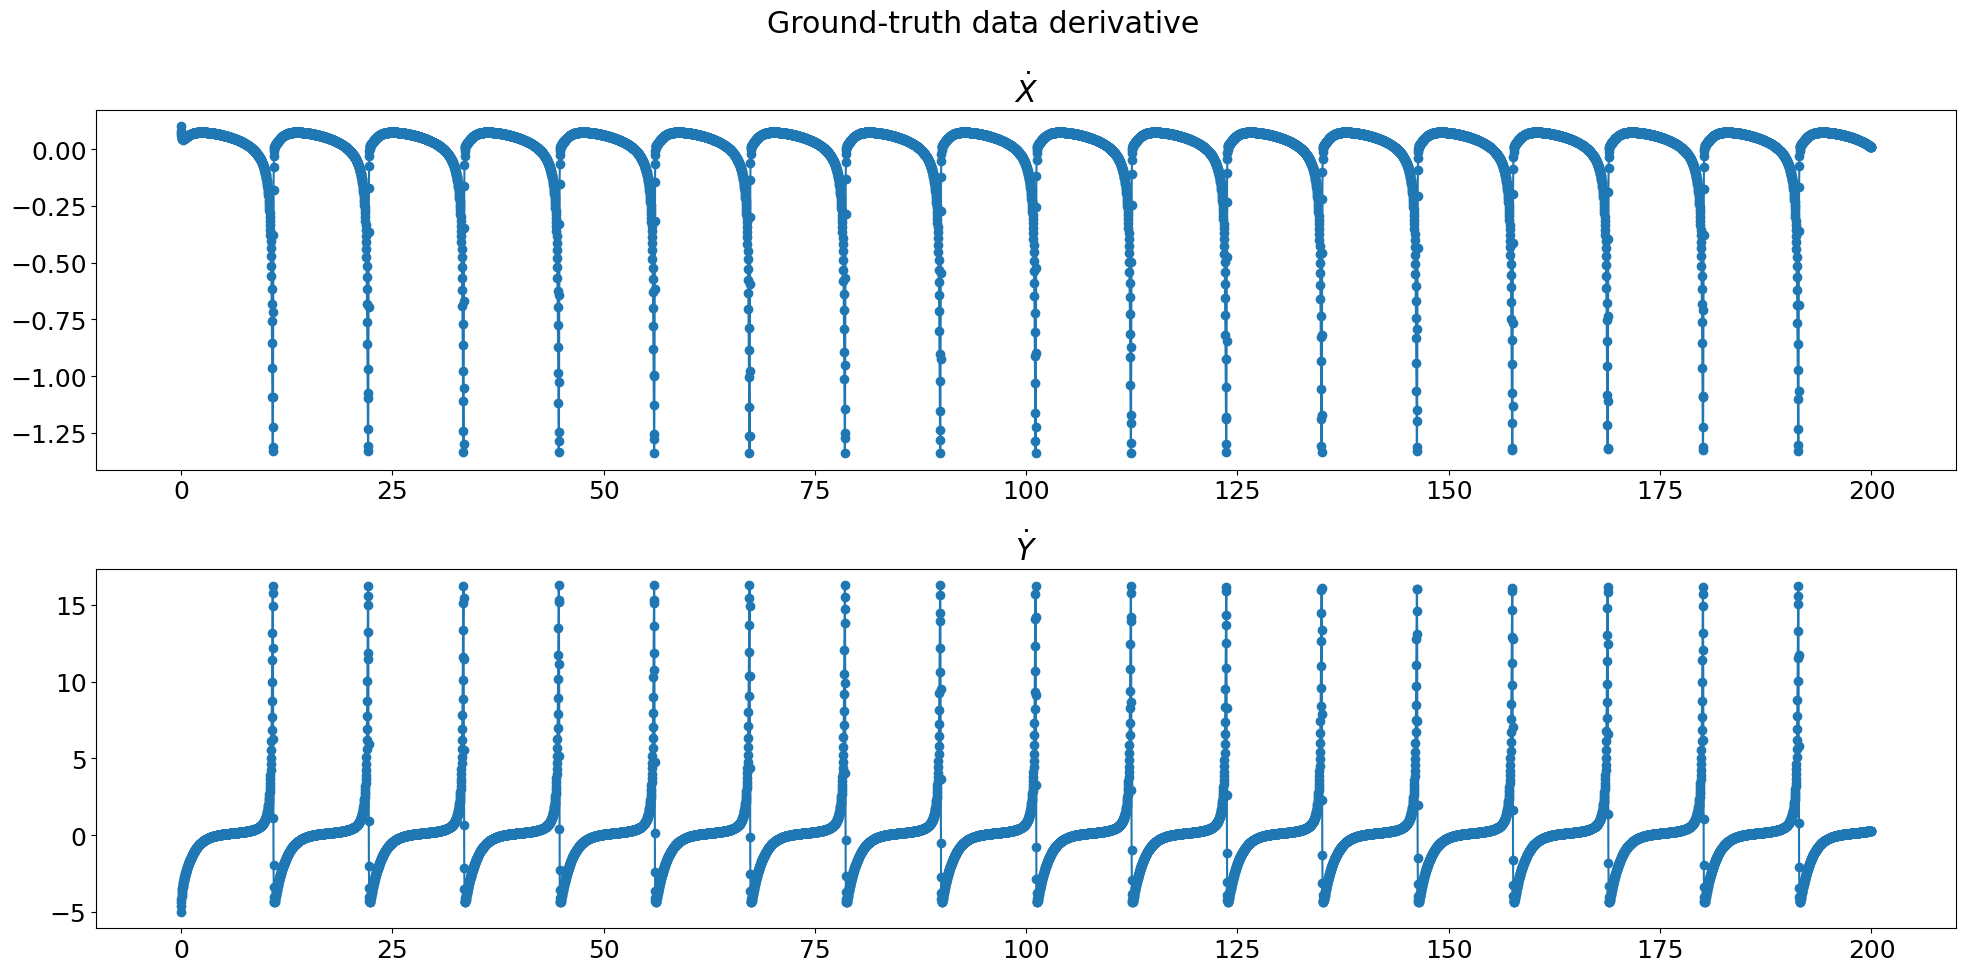

In [4]:
processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')

N_modes  = 2
x_t      = torch.Tensor(x_t).to(processor)
x        = torch.Tensor(x).to(processor)
y        = torch.Tensor(y).to(processor)
t        = torch.Tensor(t).to(processor)

A_candidates = POOL_DATA (x_t, 2, 1).to(processor)
A1A2_time_deriv = DERIVATIVE (x, y, k, a, b, mu).to(processor)

# HYPERPARAMETERS FOR THE SINDy POD METHODOLOGY
Epochs        = 20000
learning_rate = 1e-2
step_epoch    = 3000
decay_rate    = 0.50
tolerance     = 5e-3

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 0].detach().cpu().numpy(), '-o')
ax[0].set_title(r"$\dot{X}$")

ax[1].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 1].detach().cpu().numpy(), '-o')
ax[1].set_title(r"$\dot{Y}$")

fig.tight_layout()
plt.show()


In [5]:
class SINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sin(self.b*x)
        return output

class COSINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.cos(self.b*x)
        return output

class POWER_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sign(x) * torch.pow(torch.abs(x), self.b)
        return output

class EXP_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.exp(self.b*x)
        return output


In [6]:
class ADAPTIVE_SINDy_MODEL(nn.Module):
    def __init__(self, a, asine, acosine, aexp, axsine, axcosine, axexp):
        super().__init__()    
        self.a        = a
        self.asine    = asine
        self.acosine  = acosine
        self.aexp     = aexp
        self.axsine   = axsine
        self.axcosine = axcosine
        self.axexp    = axexp
        
        self.sine     = SINE_TERM   (self.asine)
        self.cosine   = COSINE_TERM (self.acosine)
        self.exp      = EXP_TERM    (self.aexp)
        self.xsine    = SINE_TERM   (self.axsine)
        self.xcosine  = COSINE_TERM (self.axcosine)
        self.xexp     = EXP_TERM    (self.axexp)
        
    def forward(self, x):
        x1             = x [:, 1:]
        output_sine    = self.sine   (x1)
        output_cosine  = self.cosine (x1)
        output_exp     = self.exp    (x1)

        output_xsine   = self.xsine   (x1)
        output_xcosine = self.xcosine (x1)
        output_xexp    = self.xexp    (x1)
 
        output_xsine   = (output_xsine  [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xcosine = (output_xcosine[:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xexp    = (output_xexp   [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        
        output = torch.hstack((x, output_sine, output_cosine, output_exp, output_xsine, output_xcosine, output_xexp)) @ self.a
        return output


In [7]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(21, N_modes, requires_grad= True, device= processor)

SINE_ADT    = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
COSINE_ADT  = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

XSINE_ADT   = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
XCOSINE_ADT = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

EXP_ADT     = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)
XEXP_ADT    = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)

In [8]:
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, EXP_ADT, XEXP_ADT], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)


# WEIGHT FUNCTION OF SINDy MODEL
WEIGHTS  = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
nn.init.normal_(WEIGHTS, mean=0, std=1)
Lambda   = Parameter(torch.tensor(1e-3), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda], maximize=False, lr = learning_rate*0.85, betas = (0.9,0.99),eps = 10**-15)


# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)

**Adaptive SINDy training**

In [9]:
# TEMPORAL MODE 1
A1_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0], EXP_ADT[:, 0], XSINE_ADT [:, 0], XCOSINE_ADT[:, 0], XEXP_ADT [:, 0]).to(processor)

# TEMPORAL MODE 2
A2_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1], EXP_ADT[:, 1], XSINE_ADT [:, 1], XCOSINE_ADT[:, 1], XEXP_ADT [:, 1]).to(processor)

Loss_data     = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    A1_out, A2_out  = A1_DT (A_candidates), A2_DT (A_candidates)
    output_data  = torch.stack((A1_out , A2_out), dim = 1)
    loss_epoch   = loss_function (A1A2_time_deriv, output_data) + (1e-3 + torch.abs(Lambda))*torch.linalg.matrix_norm(COEFF_ADT, ord =1)
    
    optim_COEFF_ADT.zero_grad()
    optim_Lambda.zero_grad()
    optim_weights.zero_grad()
    loss_epoch.backward()

    with torch.no_grad():
        optim_COEFF_ADT.step()
        optim_Lambda.step()
        optim_weights.step()
        Loss_data [epoch] = loss_epoch.detach()
        
        COEFF_ADT   [torch.abs(COEFF_ADT)   <= tolerance] = 0.0
        SINE_ADT    [torch.abs(SINE_ADT)    <= tolerance] = 0.0
        COSINE_ADT  [torch.abs(COSINE_ADT)  <= tolerance] = 0.0
        XSINE_ADT   [torch.abs(XSINE_ADT)   <= tolerance] = 0.0
        XCOSINE_ADT [torch.abs(XCOSINE_ADT) <= tolerance] = 0.0
        EXP_ADT     [torch.abs(EXP_ADT)     <= tolerance] = 0.0
        XEXP_ADT    [torch.abs(XEXP_ADT)    <= tolerance] = 0.0
        
    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)
       
    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()

LOSS DATA, [EPOCH = 0 ]: 186351.34375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1 ]: 162819.140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2 ]: 142359.4375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3 ]: 124618.078125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4 ]: 109265.78125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 5 ]: 96000.6015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 6 ]: 84549.1015625
LEARNING RATE: 0.01
***************************************************************************

LOSS DATA, [EPOCH = 60 ]: 4307.4013671875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 61 ]: 4223.00537109375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 62 ]: 4141.67529296875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 63 ]: 4063.193603515625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 64 ]: 3987.381591796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 65 ]: 3914.080078125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 66 ]: 3843.167724609375
LEARNING RATE: 0.01
*******************************************

LOSS DATA, [EPOCH = 160 ]: 1053.7593994140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 161 ]: 1041.416015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 162 ]: 1029.236328125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 163 ]: 1017.2153930664062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 164 ]: 1005.3550415039062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 165 ]: 993.6566162109375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 166 ]: 982.1067504882812
LEARNING RATE: 0.01
********************************

LOSS DATA, [EPOCH = 216 ]: 591.8677978515625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 217 ]: 586.4466552734375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 218 ]: 581.0744018554688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 219 ]: 575.750732421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 220 ]: 570.4882202148438
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 221 ]: 565.2919921875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 222 ]: 560.14111328125
LEARNING RATE: 0.01
***********************************

LOSS DATA, [EPOCH = 272 ]: 359.226318359375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 273 ]: 356.1201171875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 274 ]: 353.0478820800781
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 275 ]: 350.01953125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 276 ]: 347.0071716308594
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 277 ]: 344.0106506347656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 278 ]: 341.07452392578125
LEARNING RATE: 0.01
*************************************

LOSS DATA, [EPOCH = 364 ]: 165.78289794921875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 365 ]: 164.41685485839844
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 366 ]: 163.10223388671875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 367 ]: 161.78533935546875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 368 ]: 160.46336364746094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 369 ]: 159.1378936767578
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 370 ]: 157.8568115234375
LEARNING RATE: 0.01
************************

LOSS DATA, [EPOCH = 469 ]: 72.23222351074219
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 470 ]: 71.68960571289062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 471 ]: 71.13972473144531
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 472 ]: 70.60244750976562
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 473 ]: 70.09278106689453
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 474 ]: 69.56806182861328
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 475 ]: 69.02953338623047
LEARNING RATE: 0.01
*****************************

LOSS DATA, [EPOCH = 571 ]: 35.427974700927734
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 572 ]: 35.1948127746582
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 573 ]: 34.98869323730469
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 574 ]: 34.76494598388672
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 575 ]: 34.52743911743164
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 576 ]: 34.314998626708984
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 577 ]: 34.11122131347656
LEARNING RATE: 0.01
****************************

LOSS DATA, [EPOCH = 681 ]: 19.125492095947266
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 682 ]: 19.01913070678711
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 683 ]: 18.934650421142578
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 684 ]: 18.834409713745117
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 685 ]: 18.72170066833496
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 686 ]: 18.628915786743164
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 687 ]: 18.542335510253906
LEARNING RATE: 0.01
************************

LOSS DATA, [EPOCH = 791 ]: 10.101410865783691
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 792 ]: 10.028067588806152
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 793 ]: 9.971640586853027
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 794 ]: 9.90217113494873
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 795 ]: 9.820476531982422
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 796 ]: 9.75584602355957
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 797 ]: 9.697126388549805
LEARNING RATE: 0.01
*****************************

LOSS DATA, [EPOCH = 848 ]: 6.838437080383301
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 849 ]: 6.776154041290283
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 850 ]: 6.754721164703369
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 851 ]: 6.718985080718994
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 852 ]: 6.666916370391846
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 853 ]: 6.600093364715576
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 854 ]: 6.566818714141846
LEARNING RATE: 0.01
*****************************

LOSS DATA, [EPOCH = 905 ]: 4.624715328216553
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 906 ]: 4.596922397613525
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 907 ]: 4.577781677246094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 908 ]: 4.544181823730469
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 909 ]: 4.517380237579346
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 910 ]: 4.4894280433654785
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 911 ]: 4.4507012367248535
LEARNING RATE: 0.01
***************************

LOSS DATA, [EPOCH = 962 ]: 3.3234944343566895
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 963 ]: 3.2776033878326416
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 964 ]: 3.27803111076355
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 965 ]: 3.2823779582977295
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 966 ]: 3.263273000717163
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 967 ]: 3.2229971885681152
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 968 ]: 3.1950011253356934
LEARNING RATE: 0.01
*************************

LOSS DATA, [EPOCH = 1062 ]: 2.19757342338562
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1063 ]: 2.194956064224243
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1064 ]: 2.1900651454925537
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1065 ]: 2.1708078384399414
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1066 ]: 2.1608259677886963
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1067 ]: 2.1792497634887695
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1068 ]: 2.1735777854919434
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 1119 ]: 1.9367969036102295
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1120 ]: 1.9297269582748413
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1121 ]: 1.900040864944458
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1122 ]: 1.8828885555267334
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1123 ]: 1.896588921546936
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1124 ]: 1.885636806488037
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1125 ]: 1.8539797067642212
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 1178 ]: 1.6628706455230713
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1179 ]: 1.6367175579071045
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1180 ]: 1.6681187152862549
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1181 ]: 1.6799039840698242
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1182 ]: 1.667289137840271
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1183 ]: 1.632706642150879
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1184 ]: 1.6477094888687134
LEARNING RATE: 0.01
*****************

LOSS DATA, [EPOCH = 1285 ]: 1.2461669445037842
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1286 ]: 1.2392847537994385
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1287 ]: 1.2607412338256836
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1288 ]: 1.2579659223556519
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1289 ]: 1.2324506044387817
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1290 ]: 1.2642532587051392
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1291 ]: 1.2766035795211792
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1340 ]: 1.120941400527954
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1341 ]: 1.0933290719985962
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1342 ]: 1.0772331953048706
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1343 ]: 1.0919924974441528
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1344 ]: 1.0826448202133179
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1345 ]: 1.0537916421890259
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1346 ]: 1.0538142919540405
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1451 ]: 0.8188148140907288
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1452 ]: 0.8039265275001526
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1453 ]: 0.8195984959602356
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1454 ]: 0.8111610412597656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1455 ]: 0.7829850912094116
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1456 ]: 0.7839226126670837
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1457 ]: 0.7937335968017578
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1510 ]: 0.7224820256233215
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1511 ]: 0.7368718981742859
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1512 ]: 0.7265322804450989
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1513 ]: 0.6938733458518982
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1514 ]: 0.7115882635116577
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1515 ]: 0.7329254746437073
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1516 ]: 0.7287245392799377
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1616 ]: 0.5380640625953674
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1617 ]: 0.566691517829895
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1618 ]: 0.5661192536354065
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1619 ]: 0.5379694104194641
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1620 ]: 0.5796770453453064
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1621 ]: 0.5974885821342468
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1622 ]: 0.5857857465744019
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1675 ]: 0.46518340706825256
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1676 ]: 0.4678543508052826
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1677 ]: 0.4810549318790436
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1678 ]: 0.47371354699134827
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1679 ]: 0.4793599247932434
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1680 ]: 0.48014092445373535
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1681 ]: 0.46078842878341675
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 1735 ]: 0.46884843707084656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1736 ]: 0.46417129039764404
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1737 ]: 0.42864108085632324
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1738 ]: 0.40839534997940063
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1739 ]: 0.43196946382522583
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1740 ]: 0.42184674739837646
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1741 ]: 0.3854694068431854
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 1794 ]: 0.3613189160823822
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1795 ]: 0.3286837041378021
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1796 ]: 0.37630048394203186
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1797 ]: 0.3975614309310913
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1798 ]: 0.38427573442459106
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1799 ]: 0.33989518880844116
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1800 ]: 0.3670874834060669
LEARNING RATE: 0.01
************

LOSS DATA, [EPOCH = 1852 ]: 0.2717800736427307
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1853 ]: 0.2860792577266693
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1854 ]: 0.2785828411579132
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1855 ]: 0.28517723083496094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1856 ]: 0.28634005784988403
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1857 ]: 0.26566240191459656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1858 ]: 0.2598270773887634
LEARNING RATE: 0.01
************

LOSS DATA, [EPOCH = 1911 ]: 0.21777187287807465
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1912 ]: 0.2630428075790405
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1913 ]: 0.2833150327205658
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1914 ]: 0.2709304690361023
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1915 ]: 0.22920958697795868
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1916 ]: 0.2548163831233978
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1917 ]: 0.2840162515640259
LEARNING RATE: 0.01
*************

LOSS DATA, [EPOCH = 2001 ]: 0.14777113497257233
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2002 ]: 0.15083007514476776
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2003 ]: 0.1638214886188507
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2004 ]: 0.15744484961032867
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2005 ]: 0.1630924493074417
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2006 ]: 0.1643662452697754
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2007 ]: 0.14663392305374146
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 2055 ]: 0.13830365240573883
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2056 ]: 0.13332675397396088
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2057 ]: 0.1441102772951126
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2058 ]: 0.14457206428050995
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2059 ]: 0.1250087022781372
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2060 ]: 0.1223965659737587
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2061 ]: 0.14311565458774567
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 2140 ]: 0.12095414102077484
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2141 ]: 0.09830567240715027
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2142 ]: 0.13967397809028625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2143 ]: 0.15521612763404846
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2144 ]: 0.14626801013946533
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2145 ]: 0.11534285545349121
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2146 ]: 0.12789110839366913
LEARNING RATE: 0.01
********

LOSS DATA, [EPOCH = 2232 ]: 0.095801442861557
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2233 ]: 0.08162626624107361
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2234 ]: 0.08337552845478058
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2235 ]: 0.0869336798787117
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2236 ]: 0.08316746354103088
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2237 ]: 0.09114962816238403
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2238 ]: 0.09184397757053375
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 2287 ]: 0.11223334819078445
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2288 ]: 0.10737748444080353
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2289 ]: 0.0843750387430191
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2290 ]: 0.09269089251756668
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2291 ]: 0.10808052122592926
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2292 ]: 0.10542324185371399
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2293 ]: 0.08667954802513123
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 2343 ]: 0.06628786027431488
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2344 ]: 0.06315549463033676
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2345 ]: 0.07069753855466843
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2346 ]: 0.07131697237491608
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2347 ]: 0.058545563369989395
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2348 ]: 0.05754780024290085
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2349 ]: 0.07033248245716095
LEARNING RATE: 0.01
*******

LOSS DATA, [EPOCH = 2445 ]: 0.06470809131860733
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2446 ]: 0.04649447649717331
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2447 ]: 0.057437464594841
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2448 ]: 0.05402705818414688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2449 ]: 0.045152850449085236
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2450 ]: 0.04630327224731445
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2451 ]: 0.048081301152706146
LEARNING RATE: 0.01
********

LOSS DATA, [EPOCH = 2547 ]: 0.04250800609588623
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2548 ]: 0.039623457938432693
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2549 ]: 0.027510032057762146
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2550 ]: 0.046637047082185745
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2551 ]: 0.055156707763671875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2552 ]: 0.0533774197101593
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2553 ]: 0.042424336075782776
LEARNING RATE: 0.01
****

LOSS DATA, [EPOCH = 2656 ]: 0.034559570252895355
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2657 ]: 0.02288346365094185
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2658 ]: 0.04191537946462631
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2659 ]: 0.05035429447889328
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2660 ]: 0.048708654940128326
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2661 ]: 0.038004063069820404
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2662 ]: 0.02552633360028267
LEARNING RATE: 0.01
*****

LOSS DATA, [EPOCH = 2714 ]: 0.02111499011516571
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2715 ]: 0.028652649372816086
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2716 ]: 0.028853818774223328
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2717 ]: 0.020246973261237144
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2718 ]: 0.03564709424972534
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2719 ]: 0.04163581132888794
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2720 ]: 0.03827404975891113
LEARNING RATE: 0.01
*****

LOSS DATA, [EPOCH = 2804 ]: 0.035959478467702866
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2805 ]: 0.027416281402111053
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2806 ]: 0.017535798251628876
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2807 ]: 0.023594018071889877
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2808 ]: 0.021747669205069542
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2809 ]: 0.01677822507917881
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2810 ]: 0.017430249601602554
LEARNING RATE: 0.01
**

LOSS DATA, [EPOCH = 2913 ]: 0.0184624120593071
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2914 ]: 0.011535040102899075
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2915 ]: 0.015770122408866882
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2916 ]: 0.014484992250800133
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2917 ]: 0.011033051647245884
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2918 ]: 0.011500063352286816
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2919 ]: 0.012269802391529083
LEARNING RATE: 0.01
***

LOSS DATA, [EPOCH = 2970 ]: 0.016331598162651062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2971 ]: 0.019368406385183334
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2972 ]: 0.0176608394831419
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2973 ]: 0.011691517196595669
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2974 ]: 0.014152126386761665
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2975 ]: 0.018465779721736908
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2976 ]: 0.01794416829943657
LEARNING RATE: 0.01
****

LOSS DATA, [EPOCH = 3073 ]: 0.006918760947883129
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3074 ]: 0.009402934461832047
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3075 ]: 0.010647650808095932
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3076 ]: 0.009848113171756268
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3077 ]: 0.007210064213722944
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3078 ]: 0.009747214615345001
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3079 ]: 0.011663082055747509
LEARNING RATE: 

LOSS DATA, [EPOCH = 3173 ]: 0.0071513173170387745
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3174 ]: 0.006644593086093664
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3175 ]: 0.006021258421242237
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3176 ]: 0.006244429387152195
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3177 ]: 0.005712850484997034
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3178 ]: 0.005348862614482641
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3179 ]: 0.007089588325470686
LEARNING RATE:

LOSS DATA, [EPOCH = 3275 ]: 0.005250563379377127
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3276 ]: 0.007109642494469881
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3277 ]: 0.008576796390116215
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3278 ]: 0.008430518209934235
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3279 ]: 0.0068528540432453156
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3280 ]: 0.005057807546108961
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3281 ]: 0.006174445617944002
LEARNING RATE:

LOSS DATA, [EPOCH = 3381 ]: 0.006241906434297562
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3382 ]: 0.005761612206697464
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3383 ]: 0.004187731072306633
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3384 ]: 0.005621062126010656
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3385 ]: 0.006758953910320997
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3386 ]: 0.006643264088779688
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3387 ]: 0.005406732205301523
LEARNING RATE: 

LOSS DATA, [EPOCH = 3436 ]: 0.005013131536543369
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3437 ]: 0.0036800801753997803
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3438 ]: 0.004787764977663755
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3439 ]: 0.005745487287640572
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3440 ]: 0.005642089992761612
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3441 ]: 0.004595227539539337
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3442 ]: 0.0035021230578422546
LEARNING RATE

LOSS DATA, [EPOCH = 3533 ]: 0.004163862206041813
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3534 ]: 0.004214515443891287
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3535 ]: 0.0037148119881749153
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3536 ]: 0.00358226103708148
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3537 ]: 0.0047386628575623035
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3538 ]: 0.0048347217962145805
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3539 ]: 0.003915082663297653
LEARNING RATE

LOSS DATA, [EPOCH = 3589 ]: 0.003913898020982742
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3590 ]: 0.003975261934101582
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3591 ]: 0.003097545588389039
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3592 ]: 0.0032157248351722956
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3593 ]: 0.0037646330893039703
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3594 ]: 0.0035420802887529135
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3595 ]: 0.0037561082281172276
LEARNING RA

LOSS DATA, [EPOCH = 3645 ]: 0.0034640745725482702
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3646 ]: 0.004428533371537924
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3647 ]: 0.005364963319152594
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3648 ]: 0.005259608384221792
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3649 ]: 0.004217321984469891
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3650 ]: 0.0034328685142099857
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3651 ]: 0.004175894428044558
LEARNING RATE

LOSS DATA, [EPOCH = 3748 ]: 0.004156151786446571
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3749 ]: 0.0050846063531935215
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3750 ]: 0.0049829259514808655
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3751 ]: 0.0039539760909974575
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3752 ]: 0.003199302824214101
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3753 ]: 0.003935866057872772
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3754 ]: 0.0036612830590456724
LEARNING RA

LOSS DATA, [EPOCH = 3802 ]: 0.0025726931635290384
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3803 ]: 0.003329179948195815
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3804 ]: 0.003106077201664448
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3805 ]: 0.00312749738804996
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3806 ]: 0.0032111024484038353
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3807 ]: 0.0027398124802857637
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3808 ]: 0.0025753327645361423
LEARNING RAT

LOSS DATA, [EPOCH = 3858 ]: 0.0027298685163259506
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3859 ]: 0.0029687739443033934
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3860 ]: 0.002771464642137289
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3861 ]: 0.003202244872227311
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3862 ]: 0.003264147788286209
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3863 ]: 0.002468946622684598
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3864 ]: 0.002541723195463419
LEARNING RATE

LOSS DATA, [EPOCH = 3911 ]: 0.003342641517519951
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3912 ]: 0.0033772126771509647
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3913 ]: 0.002510421210899949
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3914 ]: 0.003824604442343116
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3915 ]: 0.004432494752109051
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3916 ]: 0.004082747735083103
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3917 ]: 0.002872244454920292
LEARNING RATE:

LOSS DATA, [EPOCH = 3966 ]: 0.0023217182606458664
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3967 ]: 0.002856495790183544
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3968 ]: 0.0026583513244986534
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3969 ]: 0.0028090174309909344
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3970 ]: 0.002879271749407053
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3971 ]: 0.002337152836844325
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3972 ]: 0.0022225382272154093
LEARNING RA

LOSS DATA, [EPOCH = 4021 ]: 0.004289480857551098
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4022 ]: 0.004207096062600613
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4023 ]: 0.003307119943201542
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4024 ]: 0.0025362176820635796
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4025 ]: 0.0031774083618074656
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4026 ]: 0.0029302877373993397
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4027 ]: 0.0023095421493053436
LEARNING RA

LOSS DATA, [EPOCH = 4121 ]: 0.0029147726017981768
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4122 ]: 0.0029746985528618097
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4123 ]: 0.002225278178229928
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4124 ]: 0.003280354430899024
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4125 ]: 0.003807380795478821
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4126 ]: 0.003477660473436117
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4127 ]: 0.0023762909695506096
LEARNING RAT

LOSS DATA, [EPOCH = 4225 ]: 0.0023615334648638964
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4226 ]: 0.002480078488588333
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4227 ]: 0.002267000963911414
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4228 ]: 0.002088069450110197
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4229 ]: 0.0029268963262438774
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4230 ]: 0.002988924738019705
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4231 ]: 0.0022168464493006468
LEARNING RAT

LOSS DATA, [EPOCH = 4278 ]: 0.0027399458922445774
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4279 ]: 0.002382884034886956
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4280 ]: 0.0025253708008676767
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4281 ]: 0.0022933960426598787
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4282 ]: 0.002100851619616151
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4283 ]: 0.002959795529022813
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4284 ]: 0.003007721621543169
LEARNING RAT

LOSS DATA, [EPOCH = 4379 ]: 0.0024314424954354763
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4380 ]: 0.0035514396149665117
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4381 ]: 0.004392768256366253
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4382 ]: 0.004277469590306282
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4383 ]: 0.0033645774237811565
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4384 ]: 0.0023507210426032543
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4385 ]: 0.0029995550867170095
LEARNING R

LOSS DATA, [EPOCH = 4438 ]: 0.002276490442454815
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4439 ]: 0.0029287964571267366
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4440 ]: 0.002676439704373479
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4441 ]: 0.0024138365406543016
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4442 ]: 0.002534196712076664
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4443 ]: 0.0022205489221960306
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4444 ]: 0.00203903391957283
LEARNING RATE

LOSS DATA, [EPOCH = 4492 ]: 0.0022770147770643234
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4493 ]: 0.002932825591415167
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4494 ]: 0.0026821549981832504
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4495 ]: 0.002414852613583207
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4496 ]: 0.0025330018252134323
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4497 ]: 0.0022223691921681166
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4498 ]: 0.0020426283590495586
LEARNING R

LOSS DATA, [EPOCH = 4552 ]: 0.002042435109615326
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4553 ]: 0.003011069493368268
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4554 ]: 0.0030719349160790443
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4555 ]: 0.0022647578734904528
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4556 ]: 0.003313014516606927
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4557 ]: 0.003876272588968277
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4558 ]: 0.003515686606988311
LEARNING RATE

LOSS DATA, [EPOCH = 4611 ]: 0.00385549059137702
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4612 ]: 0.0035097841173410416
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4613 ]: 0.0023567932657897472
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4614 ]: 0.0035405175294727087
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4615 ]: 0.004390235990285873
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4616 ]: 0.004313085228204727
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4617 ]: 0.003402065485715866
LEARNING RATE

LOSS DATA, [EPOCH = 4668 ]: 0.003535081399604678
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4669 ]: 0.004386966582387686
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4670 ]: 0.004309915937483311
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4671 ]: 0.0033965271431952715
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4672 ]: 0.002282222965732217
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4673 ]: 0.0029375844169408083
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4674 ]: 0.0026840739883482456
LEARNING RAT

LOSS DATA, [EPOCH = 4722 ]: 0.0035327214282006025
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4723 ]: 0.004383189603686333
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4724 ]: 0.004306647926568985
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4725 ]: 0.003396431915462017
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4726 ]: 0.0022877610754221678
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4727 ]: 0.002943648025393486
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4728 ]: 0.002695114817470312
LEARNING RATE

LOSS DATA, [EPOCH = 4812 ]: 0.0035386316012591124
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4813 ]: 0.004388619679957628
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4814 ]: 0.004312544129788876
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4815 ]: 0.003403621958568692
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4816 ]: 0.0022815747652202845
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4817 ]: 0.0029422517400234938
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4818 ]: 0.0026989614125341177
LEARNING RA

LOSS DATA, [EPOCH = 4919 ]: 0.002371897455304861
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4920 ]: 0.003549577435478568
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4921 ]: 0.004396127536892891
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4922 ]: 1.2566933631896973
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4923 ]: 0.005298158619552851
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4924 ]: 0.00832126010209322
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4925 ]: 0.013150854036211967
LEARNING RATE: 0.0

LOSS DATA, [EPOCH = 5027 ]: 0.0024041677825152874
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5028 ]: 0.0035792537964880466
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5029 ]: 0.004429323133081198
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5030 ]: 0.004351679235696793
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5031 ]: 0.0034395097754895687
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5032 ]: 0.002324453555047512
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5033 ]: 0.002978862961754203
LEARNING RAT

LOSS DATA, [EPOCH = 5081 ]: 0.0023957141675055027
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5082 ]: 0.003567229490727186
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5083 ]: 0.004417048301547766
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5084 ]: 0.004338962957262993
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5085 ]: 0.0034262058325111866
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5086 ]: 0.002313882578164339
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5087 ]: 0.00296790967695415
LEARNING RATE:

LOSS DATA, [EPOCH = 5171 ]: 0.002395265270024538
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5172 ]: 0.003554598893970251
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5173 ]: 0.004403553903102875
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5174 ]: 0.0043293749913573265
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5175 ]: 0.0034209920559078455
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5176 ]: 0.002315976656973362
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5177 ]: 0.002980085788294673
LEARNING RATE

LOSS DATA, [EPOCH = 5230 ]: 0.0022809545043855906
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5231 ]: 0.0029360223561525345
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5232 ]: 0.002684210892766714
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5233 ]: 0.0024468512274324894
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5234 ]: 0.002571431454271078
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5235 ]: 0.0022383963223546743
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5236 ]: 0.0020705668721348047
LEARNING R

LOSS DATA, [EPOCH = 5322 ]: 0.0036461330018937588
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5323 ]: 0.002464498160406947
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5324 ]: 0.003494704607874155
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5325 ]: 0.004365311004221439
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5326 ]: 0.004306093789637089
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5327 ]: 0.003410534467548132
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5328 ]: 0.002282035304233432
LEARNING RATE:

LOSS DATA, [EPOCH = 5380 ]: 0.003513574367389083
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5381 ]: 0.004029193427413702
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5382 ]: 0.0036515165120363235
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5383 ]: 0.002470929641276598
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5384 ]: 0.0034799412824213505
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5385 ]: 0.004354147240519524
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5386 ]: 0.0042969523929059505
LEARNING RAT

LOSS DATA, [EPOCH = 5484 ]: 0.003463772125542164
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5485 ]: 0.004337259568274021
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5486 ]: 0.004280064254999161
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5487 ]: 0.003385293297469616
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5488 ]: 0.002304431749507785
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5489 ]: 0.002944205654785037
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5490 ]: 0.0026774764992296696
LEARNING RATE:

LOSS DATA, [EPOCH = 5586 ]: 0.003449684241786599
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5587 ]: 0.003966867923736572
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5588 ]: 0.003591407323256135
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5589 ]: 0.002410501940175891
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5590 ]: 0.003528142347931862
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5591 ]: 0.004400246310979128
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5592 ]: 0.004342925269156694
LEARNING RATE: 

LOSS DATA, [EPOCH = 5686 ]: 0.0043532648123800755
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5687 ]: 0.003467316972091794
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5688 ]: 0.002198835602030158
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5689 ]: 0.002831916091963649
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5690 ]: 0.0025598849169909954
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5691 ]: 0.0025531079154461622
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5692 ]: 0.0026889091823250055
LEARNING RA

LOSS DATA, [EPOCH = 5743 ]: 0.002321666805073619
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5744 ]: 0.0036102074664086103
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5745 ]: 0.004481717944145203
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5746 ]: 0.004423705395311117
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5747 ]: 0.0035296364221721888
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5748 ]: 0.002143322955816984
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5749 ]: 0.0027828251477330923
LEARNING RAT

LOSS DATA, [EPOCH = 5802 ]: 0.003517686389386654
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5803 ]: 0.0023384622763842344
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5804 ]: 0.0035950616002082825
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5805 ]: 0.00446775509044528
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5806 ]: 0.004407290369272232
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5807 ]: 0.003509287489578128
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5808 ]: 0.002160226460546255
LEARNING RATE:

LOSS DATA, [EPOCH = 5857 ]: 0.002776515204459429
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5858 ]: 0.002883383072912693
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5859 ]: 0.0021363182459026575
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5860 ]: 0.0033949578646570444
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5861 ]: 0.003915521316230297
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5862 ]: 0.003540670033544302
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5863 ]: 0.002359317149966955
LEARNING RATE

LOSS DATA, [EPOCH = 5911 ]: 0.002532167360186577
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5912 ]: 0.002663146471604705
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5913 ]: 0.0020761415362358093
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5914 ]: 0.002129205036908388
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5915 ]: 0.002557964064180851
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5916 ]: 0.0023200709838420153
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5917 ]: 0.002756420522928238
LEARNING RATE

LOSS DATA, [EPOCH = 6007 ]: 0.0020068641752004623
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6008 ]: 0.0028251977637410164
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6009 ]: 0.003145687049254775
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6010 ]: 0.0030120701994746923
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6011 ]: 0.002469903090968728
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6012 ]: 0.002446739701554179
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6013 ]: 0.002843588823452592
LEARNI

LOSS DATA, [EPOCH = 6063 ]: 0.0025149183347821236
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6064 ]: 0.0023660273291170597
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6065 ]: 0.0027324394322931767
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6066 ]: 0.0026405337266623974
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6067 ]: 0.0021361056715250015
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6068 ]: 0.0027446243911981583
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6069 ]: 0.003111017169430852
LEA

LOSS DATA, [EPOCH = 6124 ]: 0.0027335232589393854
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6125 ]: 0.003099756082519889
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6126 ]: 0.0030075660906732082
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6127 ]: 0.002503126161172986
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6128 ]: 0.0023757198359817266
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6129 ]: 0.0027420753613114357
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6130 ]: 0.0026502786204218864
LEAR

LOSS DATA, [EPOCH = 6178 ]: 0.002643431071192026
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6179 ]: 0.0021381983533501625
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6180 ]: 0.002739052986726165
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6181 ]: 0.0031058494932949543
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6182 ]: 0.003013741923496127
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6183 ]: 0.0025090225972235203
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6184 ]: 0.0023677817080169916
LEARN

LOSS DATA, [EPOCH = 6282 ]: 0.0026236579287797213
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6283 ]: 0.0021200706250965595
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6284 ]: 0.002760357456281781
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6285 ]: 0.003125221701338887
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6286 ]: 0.003034063382074237
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6287 ]: 0.002531204139813781
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6288 ]: 0.0023463440593332052
LEARNI

LOSS DATA, [EPOCH = 6369 ]: 0.0026911585591733456
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6370 ]: 0.0025991180445998907
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6371 ]: 0.00209432072006166
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6372 ]: 0.002779579721391201
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6373 ]: 0.003148601623252034
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6374 ]: 0.0030546633061021566
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6375 ]: 0.0025508468970656395
LEARNI

LOSS DATA, [EPOCH = 6426 ]: 0.002583084860816598
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6427 ]: 0.0020782658830285072
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6428 ]: 0.002794098574668169
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6429 ]: 0.003160701133310795
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6430 ]: 0.003068978665396571
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6431 ]: 0.002564811147749424
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6432 ]: 0.0023068818263709545
LEARNIN

LOSS DATA, [EPOCH = 6482 ]: 0.002568885451182723
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6483 ]: 0.0020640853326767683
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6484 ]: 0.0028074695728719234
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6485 ]: 0.003174026031047106
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6486 ]: 0.003081858390942216
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6487 ]: 0.0025773041415959597
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6488 ]: 0.0022944186348468065
LEARN

LOSS DATA, [EPOCH = 6577 ]: 0.0026573180221021175
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6578 ]: 0.0025663606356829405
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6579 ]: 0.0020610406063497066
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6580 ]: 0.002811369253322482
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6581 ]: 0.0031766186002641916
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6582 ]: 0.00308465538546443
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6583 ]: 0.002579045481979847
LEARNI

LOSS DATA, [EPOCH = 6636 ]: 0.0028114060405641794
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6637 ]: 0.003179834922775626
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6638 ]: 0.003090237034484744
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6639 ]: 0.0025812650565057993
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6640 ]: 0.0022924260701984167
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6641 ]: 0.0026592027861624956
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6642 ]: 0.002564002526924014
LEARN

LOSS DATA, [EPOCH = 6694 ]: 0.003068989608436823
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6695 ]: 0.00256406725384295
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6696 ]: 0.002307028276845813
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6697 ]: 0.0026737500447779894
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6698 ]: 0.0025820571463555098
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6699 ]: 0.0020777233876287937
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6700 ]: 0.0027927185874432325
LEARNI

LOSS DATA, [EPOCH = 6754 ]: 0.0025836373679339886
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6755 ]: 0.0020795005839318037
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6756 ]: 0.0027935830876231194
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6757 ]: 0.0031601081136614084
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6758 ]: 0.003069028491154313
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6759 ]: 0.0025638227816671133
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6760 ]: 0.0023077819496393204
LEA

LOSS DATA, [EPOCH = 6806 ]: 0.0030591203831136227
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6807 ]: 0.002554673934355378
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6808 ]: 0.0023163503501564264
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6809 ]: 0.0026827016845345497
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6810 ]: 0.0025909598916769028
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6811 ]: 0.002086302964016795
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6812 ]: 0.002784495474770665
LEARN

LOSS DATA, [EPOCH = 6863 ]: 0.0025617615319788456
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6864 ]: 0.002308961469680071
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6865 ]: 0.0026752601843327284
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6866 ]: 0.0025834091939032078
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6867 ]: 0.002078618388622999
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6868 ]: 0.0027924892492592335
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6869 ]: 0.0031590431462973356
LEAR

LOSS DATA, [EPOCH = 6968 ]: 0.002283720299601555
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6969 ]: 0.0026500513777136803
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6970 ]: 0.002558154286816716
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6971 ]: 0.0020531322807073593
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6972 ]: 0.0028184629045426846
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6973 ]: 0.0031850975938141346
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6974 ]: 0.003093346720561385
LEARN

LOSS DATA, [EPOCH = 7026 ]: 0.0025414777919650078
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7027 ]: 0.0020363314542919397
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7028 ]: 0.002834790851920843
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7029 ]: 0.0032017123885452747
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7030 ]: 0.003110197139903903
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7031 ]: 0.0026060333475470543
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7032 ]: 0.0022656393703073263
LEAR

LOSS DATA, [EPOCH = 7084 ]: 0.002855022205039859
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7085 ]: 0.0032225523609668016
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7086 ]: 0.003131852252408862
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7087 ]: 0.002628300106152892
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7088 ]: 0.0022483239881694317
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7089 ]: 0.002613418037071824
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7090 ]: 0.0025199130177497864
LEARNI

LOSS DATA, [EPOCH = 7144 ]: 0.0022296644747257233
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7145 ]: 0.002594270510599017
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7146 ]: 0.0024995594285428524
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7147 ]: 0.002000668551772833
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7148 ]: 0.0020350038539618254
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7149 ]: 0.0023563310969620943
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7150 ]: 0.002286029513925314
LEARN

LOSS DATA, [EPOCH = 7203 ]: 0.002595260739326477
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7204 ]: 0.0022701877169311047
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7205 ]: 0.0026324738282710314
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7206 ]: 0.002536861225962639
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7207 ]: 0.0020290932152420282
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7208 ]: 0.002849460346624255
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7209 ]: 0.003220892045646906
LEARNI

LOSS DATA, [EPOCH = 7263 ]: 0.002001906046643853
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7264 ]: 0.0028041480109095573
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7265 ]: 0.0031130523420870304
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7266 ]: 0.0029690605588257313
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7267 ]: 0.002417665673419833
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7268 ]: 0.002497601555660367
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7269 ]: 0.00290342653170228
LEARNIN

LOSS DATA, [EPOCH = 7322 ]: 0.0025021620094776154
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7323 ]: 0.002000447129830718
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7324 ]: 0.002033355413004756
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7325 ]: 0.002358050551265478
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7326 ]: 0.0022892849519848824
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7327 ]: 0.0021921563893556595
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7328 ]: 0.002204384421929717
LEARNI

LOSS DATA, [EPOCH = 7380 ]: 0.0022792378440499306
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7381 ]: 0.0026339360047131777
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7382 ]: 0.002540393965318799
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7383 ]: 0.0020348834805190563
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7384 ]: 0.002845403039827943
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7385 ]: 0.0032161094713956118
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7386 ]: 0.003129436634480953
LEARN

LOSS DATA, [EPOCH = 7434 ]: 0.0031339088454842567
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7435 ]: 0.0026288521476089954
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7436 ]: 0.002241821028292179
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7437 ]: 0.0026085716672241688
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7438 ]: 0.002516837790608406
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7439 ]: 0.002012438839301467
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7440 ]: 0.0028574320022016764
LEARN

LOSS DATA, [EPOCH = 7540 ]: 0.0022343045566231012
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7541 ]: 0.002600613981485367
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7542 ]: 0.002508866833522916
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7543 ]: 0.002003967994824052
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7544 ]: 0.0028692830819636583
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7545 ]: 0.003238954581320286
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7546 ]: 0.0031524018850177526
LEARNI

LOSS DATA, [EPOCH = 7630 ]: 0.002867046743631363
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7631 ]: 0.0032342278864234686
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7632 ]: 0.003142843022942543
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7633 ]: 0.002638855017721653
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7634 ]: 0.0022308893967419863
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7635 ]: 0.0025969925336539745
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7636 ]: 0.0025048949755728245
LEARN

LOSS DATA, [EPOCH = 7686 ]: 0.00247393106110394
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7687 ]: 0.0028157616034150124
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7688 ]: 0.0027014364022761583
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7689 ]: 0.0021766202989965677
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7690 ]: 0.0027112795505672693
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7691 ]: 0.003094317391514778
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7692 ]: 0.003016976173967123
LEARNI

LOSS DATA, [EPOCH = 7741 ]: 0.002190585946664214
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7742 ]: 0.0022037059534341097
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7743 ]: 0.002200003946200013
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7744 ]: 0.002147010061889887
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7745 ]: 0.002316629746928811
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7746 ]: 0.0023172295186668634
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7747 ]: 0.00209774705581367
LEARNING

LOSS DATA, [EPOCH = 7846 ]: 0.002314455807209015
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7847 ]: 0.002165041631087661
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7848 ]: 0.0021808198653161526
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7849 ]: 0.002220288384705782
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7850 ]: 0.002165299141779542
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7851 ]: 0.002299131592735648
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7852 ]: 0.0023013665340840816
LEARNIN

LOSS DATA, [EPOCH = 7938 ]: 0.002029457362368703
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7939 ]: 0.0023565266747027636
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7940 ]: 0.0022882609628140926
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7941 ]: 0.0021886052563786507
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7942 ]: 0.002201639348641038
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7943 ]: 0.0022016363218426704
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7944 ]: 0.002148844301700592
LEARN

LOSS DATA, [EPOCH = 8030 ]: 0.0019992555025964975
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8031 ]: 0.0023852973245084286
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8032 ]: 0.0023128939792513847
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8033 ]: 0.0021667235996574163
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8034 ]: 0.00218304549343884
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8035 ]: 0.002219049260020256
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8036 ]: 0.002163521945476532
LEARNI

LOSS DATA, [EPOCH = 8085 ]: 0.003230844857171178
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8086 ]: 0.0031388611532747746
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8087 ]: 0.002635710407048464
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8088 ]: 0.002235078252851963
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8089 ]: 0.002601214684545994
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8090 ]: 0.0025076966267079115
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8091 ]: 0.0020006971899420023
LEARNI

LOSS DATA, [EPOCH = 8190 ]: 0.002147749997675419
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8191 ]: 0.00231576943770051
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8192 ]: 0.002316555241122842
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8193 ]: 0.002098222728818655
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8194 ]: 0.002055673860013485
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8195 ]: 0.0023992375936359167
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8196 ]: 0.0023912107571959496
LEARNING

LOSS DATA, [EPOCH = 8300 ]: 0.002066410845145583
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8301 ]: 0.002388513181358576
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8302 ]: 0.0023821506183594465
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8303 ]: 0.002039586892351508
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8304 ]: 0.0020028380677103996
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8305 ]: 0.0024471688084304333
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8306 ]: 0.0024352925829589367
LEARN

LOSS DATA, [EPOCH = 8359 ]: 0.001998120453208685
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8360 ]: 0.0028727848548442125
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8361 ]: 0.0032414868474006653
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8362 ]: 0.003151113400235772
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8363 ]: 0.002646115142852068
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8364 ]: 0.0022259638644754887
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8365 ]: 0.002591670723631978
LEARNI

LOSS DATA, [EPOCH = 8413 ]: 0.003096139058470726
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8414 ]: 0.0030192704871296883
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8415 ]: 0.0025287342723459005
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8416 ]: 0.0023358215112239122
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8417 ]: 0.0026953103952109814
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8418 ]: 0.0025952556170523167
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8419 ]: 0.0020774714648723602
LEA

LOSS DATA, [EPOCH = 8467 ]: 0.002001633867621422
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8468 ]: 0.0028682274278253317
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8469 ]: 0.0032346672378480434
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8470 ]: 0.0031423738691955805
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8471 ]: 0.002637722296640277
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8472 ]: 0.002232347847893834
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8473 ]: 0.0025987778790295124
LEARN

LOSS DATA, [EPOCH = 8570 ]: 0.003123639151453972
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8571 ]: 0.002621077001094818
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8572 ]: 0.0022463868372142315
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8573 ]: 0.0026113500352948904
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8574 ]: 0.002517816610634327
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8575 ]: 0.0020111955236643553
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8576 ]: 0.0028607118874788284
LEARN

LOSS DATA, [EPOCH = 8629 ]: 0.002450588159263134
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8630 ]: 0.0024372306652367115
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8631 ]: 0.002002499531954527
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8632 ]: 0.002802668372169137
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8633 ]: 0.003111797384917736
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8634 ]: 0.0029680703300982714
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8635 ]: 0.0024163664784282446
LEARNI

LOSS DATA, [EPOCH = 8686 ]: 0.0022861205507069826
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8687 ]: 0.0021917682606726885
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8688 ]: 0.002204654971137643
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8689 ]: 0.0021978910081088543
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8690 ]: 0.002144904574379325
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8691 ]: 0.0023181866854429245
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8692 ]: 0.002319029299542308
LEARN

LOSS DATA, [EPOCH = 8795 ]: 0.002035206649452448
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8796 ]: 0.0019981255754828453
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8797 ]: 0.002449775580316782
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8798 ]: 0.002437625313177705
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8799 ]: 0.002003878355026245
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8800 ]: 0.002801070688292384
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8801 ]: 0.003109908429905772
LEARNING

LOSS DATA, [EPOCH = 8849 ]: 0.0025961981154978275
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8850 ]: 0.0024990695528686047
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8851 ]: 0.0020017391070723534
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8852 ]: 0.0020383428782224655
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8853 ]: 0.002353142946958542
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8854 ]: 0.002283540554344654
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8855 ]: 0.0021968723740428686
LEAR

LOSS DATA, [EPOCH = 8907 ]: 0.002600448438897729
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8908 ]: 0.002263592556118965
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8909 ]: 0.002625728026032448
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8910 ]: 0.0025295314844697714
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8911 ]: 0.0020206046756356955
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8912 ]: 0.002852024743333459
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8913 ]: 0.003221942577511072
LEARNIN

LOSS DATA, [EPOCH = 9002 ]: 0.0021562394686043262
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9003 ]: 0.002341232495382428
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9004 ]: 0.002296529011800885
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9005 ]: 0.0020451191812753677
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9006 ]: 0.0023842304944992065
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9007 ]: 0.0025667548179626465
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9008 ]: 0.002519834088161587

LOSS DATA, [EPOCH = 9097 ]: 0.0022562111262232065
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9098 ]: 0.002174238208681345
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9099 ]: 0.0023578102700412273
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9100 ]: 0.0023118203971534967
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9101 ]: 0.0020592135842889547
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9102 ]: 0.002371127251535654
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9103 ]: 0.002554617589339614

LOSS DATA, [EPOCH = 9200 ]: 0.0025087427347898483
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9201 ]: 0.0022560355719178915
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9202 ]: 0.002174452180042863
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9203 ]: 0.002358019119128585
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9204 ]: 0.0023120176047086716
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9205 ]: 0.0020592978689819574
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9206 ]: 0.002371116075664758

LOSS DATA, [EPOCH = 9255 ]: 0.0025543116498738527
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9256 ]: 0.002508490579202771
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9257 ]: 0.0022561729419976473
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9258 ]: 0.002175598405301571
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9259 ]: 0.0023598026018589735
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9260 ]: 0.0023141095880419016
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9261 ]: 0.002060993108898401

LOSS DATA, [EPOCH = 9308 ]: 0.0023099093232303858
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9309 ]: 0.0020572261419147253
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9310 ]: 0.002373190363869071
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9311 ]: 0.0025567160919308662
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9312 ]: 0.002510681049898267
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9313 ]: 0.0022580837830901146
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9314 ]: 0.002172290580347180

LOSS DATA, [EPOCH = 9364 ]: 0.0023067258298397064
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9365 ]: 0.00205401424318552
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9366 ]: 0.002376481657847762
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9367 ]: 0.0025600448716431856
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9368 ]: 0.0025140384677797556
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9369 ]: 0.002261444693431258
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9370 ]: 0.002168868901208043
L

LOSS DATA, [EPOCH = 9418 ]: 0.002165402052924037
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9419 ]: 0.0023489370942115784
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9420 ]: 0.002302881795912981
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9421 ]: 0.00205008452758193
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9422 ]: 0.002380700781941414
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9423 ]: 0.0025642388500273228
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9424 ]: 0.0025182184763252735
L

LOSS DATA, [EPOCH = 9521 ]: 0.0022729889024049044
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9522 ]: 0.00215730769559741
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9523 ]: 0.002340946113690734
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9524 ]: 0.0022949264384806156
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9525 ]: 0.0020420434884727
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9526 ]: 0.0023885720875114202
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9527 ]: 0.0025721199344843626
LE

LOSS DATA, [EPOCH = 9576 ]: 0.002530110999941826
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9577 ]: 0.002277468331158161
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9578 ]: 0.002153297420591116
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9579 ]: 0.0023366529494524
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9580 ]: 0.0022901780903339386
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9581 ]: 0.0020375042222440243
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9582 ]: 0.0023933234624564648
LE

LOSS DATA, [EPOCH = 9634 ]: 0.002151377499103546
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9635 ]: 0.0023349039256572723
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9636 ]: 0.002288935938850045
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9637 ]: 0.0020362818613648415
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9638 ]: 0.0023950343020260334
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9639 ]: 0.0025789798237383366
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9640 ]: 0.002533312654122710

LOSS DATA, [EPOCH = 9737 ]: 0.0022874565329402685
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9738 ]: 0.0021441609133034945
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9739 ]: 0.0023276156280189753
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9740 ]: 0.0022812990937381983
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9741 ]: 0.002028144197538495
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9742 ]: 0.0024023926816880703
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9743 ]: 0.00258606742136180

LOSS DATA, [EPOCH = 9837 ]: 0.0020205965265631676
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9838 ]: 0.002409870270639658
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9839 ]: 0.0025934837758541107
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9840 ]: 0.0025475681759417057
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9841 ]: 0.0022950554266572
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9842 ]: 0.002135627903044224
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9843 ]: 0.00231924862600863
LEA

LOSS DATA, [EPOCH = 9895 ]: 0.0025981308426707983
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9896 ]: 0.0025523880030959845
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9897 ]: 0.002300061285495758
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9898 ]: 0.0021309852600097656
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9899 ]: 0.0023142460267990828
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9900 ]: 0.0022679560352116823
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9901 ]: 0.00201509939506649

LOSS DATA, [EPOCH = 9985 ]: 0.002306368201971054
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9986 ]: 0.00212394492700696
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9987 ]: 0.0023073877673596144
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9988 ]: 0.0022613471373915672
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9989 ]: 0.002008552197366953
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9990 ]: 0.0024218419566750526
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9991 ]: 0.002605434972792864
L

LOSS DATA, [EPOCH = 10039 ]: 0.002608634065836668
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10040 ]: 0.0025626462884247303
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10041 ]: 0.0023101114202290773
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10042 ]: 0.002120264805853367
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10043 ]: 0.002303693676367402
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10044 ]: 0.0022576639894396067
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10045 ]: 0.002004918409

LOSS DATA, [EPOCH = 10097 ]: 0.00231451285071671
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10098 ]: 0.0021157446317374706
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10099 ]: 0.0022991623263806105
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10100 ]: 0.0022531154099851847
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10101 ]: 0.0020003190729767084
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10102 ]: 0.0024301507510244846
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10103 ]: 0.00261381198

LOSS DATA, [EPOCH = 10149 ]: 0.0019959493074566126
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10150 ]: 0.002434629015624523
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10151 ]: 0.0026182944420725107
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10152 ]: 0.002572275698184967
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10153 ]: 0.002319599036127329
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10154 ]: 0.002110757865011692
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10155 ]: 0.0022941783536

LOSS DATA, [EPOCH = 10253 ]: 0.0020462442189455032
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10254 ]: 0.0020248389337211847
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10255 ]: 0.0021973727270960808
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10256 ]: 0.002193534281104803
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10257 ]: 0.0020127149764448404
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10258 ]: 0.0019966894760727882
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10259 ]: 0.0021899067

LOSS DATA, [EPOCH = 10310 ]: 0.002256000880151987
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10311 ]: 0.0020017048809677362
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10312 ]: 0.0024294848553836346
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10313 ]: 0.0026140217669308186
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10314 ]: 0.002568943193182349
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10315 ]: 0.0023167214822024107
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10316 ]: 0.00211370526

LOSS DATA, [EPOCH = 10364 ]: 0.002245771698653698
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10365 ]: 0.002448583487421274
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10366 ]: 0.00241975300014019
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10367 ]: 0.0021823274437338114
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10368 ]: 0.002234844956547022
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10369 ]: 0.0024056527763605118
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10370 ]: 0.00234825955703

LOSS DATA, [EPOCH = 10419 ]: 0.0019972408190369606
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10420 ]: 0.0020134432706981897
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10421 ]: 0.002174775581806898
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10422 ]: 0.0021404162980616093
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10423 ]: 0.0020930878818035126
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10424 ]: 0.0020997754763811827
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10425 ]: 0.0020969994

LOSS DATA, [EPOCH = 10473 ]: 0.002588211093097925
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10474 ]: 0.0025451728142797947
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10475 ]: 0.002295263111591339
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10476 ]: 0.0021325740963220596
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10477 ]: 0.002313819248229265
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10478 ]: 0.0022655159700661898
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10479 ]: 0.002010912168

LOSS DATA, [EPOCH = 10563 ]: 0.0020121042616665363
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10564 ]: 0.0024205546360462904
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10565 ]: 0.002606046386063099
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10566 ]: 0.0025617489591240883
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10567 ]: 0.002310298616066575
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10568 ]: 0.0021209712140262127
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10569 ]: 0.00230278889

LOSS DATA, [EPOCH = 10623 ]: 0.0020170945208519697
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10624 ]: 0.0019986138213425875
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10625 ]: 0.0022205663844943047
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10626 ]: 0.00221442524343729
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10627 ]: 0.001997586339712143
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10628 ]: 0.0024005749728530645
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10629 ]: 0.002555560553

LOSS DATA, [EPOCH = 10675 ]: 0.002316833473742008
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10676 ]: 0.0021131739486008883
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10677 ]: 0.0022965583484619856
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10678 ]: 0.002250372665002942
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10679 ]: 0.001997520914301276
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10680 ]: 0.002432721434161067
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10681 ]: 0.0026163614820

LOSS DATA, [EPOCH = 10730 ]: 0.002141518285498023
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10731 ]: 0.0020923272240906954
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10732 ]: 0.0020990571938455105
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10733 ]: 0.002098222728818655
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10734 ]: 0.002071473514661193
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10735 ]: 0.0021550478413701057
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10736 ]: 0.002155549824

LOSS DATA, [EPOCH = 10788 ]: 0.002419335301965475
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10789 ]: 0.002604799112305045
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10790 ]: 0.002560136141255498
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10791 ]: 0.0023082811385393143
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10792 ]: 0.002120870165526867
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10793 ]: 0.002303660148754716
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10794 ]: 0.00225688191130

LOSS DATA, [EPOCH = 10843 ]: 0.001996061997488141
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10844 ]: 0.0020122569985687733
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10845 ]: 0.002175777917727828
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10846 ]: 0.0021416740491986275
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10847 ]: 0.0020924259442836046
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10848 ]: 0.002099571516737342
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10849 ]: 0.002100077923

LOSS DATA, [EPOCH = 10945 ]: 0.0020461459644138813
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10946 ]: 0.0020249742083251476
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10947 ]: 0.0021976346615701914
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10948 ]: 0.0021935557015240192
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10949 ]: 0.0020124376751482487
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10950 ]: 0.001997098559513688
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10951 ]: 0.0021897288

LOSS DATA, [EPOCH = 11041 ]: 0.0021478666458278894
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11042 ]: 0.0021490156650543213
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11043 ]: 0.0020524843130260706
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11044 ]: 0.002030419185757637
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11045 ]: 0.002191922627389431
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11046 ]: 0.0021886639297008514
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11047 ]: 0.00201681209

LOSS DATA, [EPOCH = 11141 ]: 0.002220825059339404
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11142 ]: 0.002214686945080757
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11143 ]: 0.001997509738430381
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11144 ]: 0.0024002341087907553
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11145 ]: 0.0025549624115228653
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11146 ]: 0.002482733456417918
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11147 ]: 0.0022062528878

LOSS DATA, [EPOCH = 11193 ]: 0.0022954214364290237
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11194 ]: 0.0022494171280413866
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11195 ]: 0.0019965916872024536
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11196 ]: 0.0024354741908609867
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11197 ]: 0.0026189805939793587
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11198 ]: 0.002572696190327406
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11199 ]: 0.0023198851

LOSS DATA, [EPOCH = 11294 ]: 0.002248115371912718
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11295 ]: 0.001996039878576994
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11296 ]: 0.0020122304558753967
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11297 ]: 0.0021756510250270367
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11298 ]: 0.0021414002403616905
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11299 ]: 0.002091955626383424
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11300 ]: 0.002098550088

LOSS DATA, [EPOCH = 11384 ]: 0.002111251000314951
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11385 ]: 0.002294468227773905
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11386 ]: 0.00224863039329648
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11387 ]: 0.00199647294357419
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11388 ]: 0.0020126686431467533
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11389 ]: 0.0021759015507996082
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11390 ]: 0.002141412813216

LOSS DATA, [EPOCH = 11436 ]: 0.002163982018828392
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11437 ]: 0.0023423158563673496
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11438 ]: 0.002291621407493949
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11439 ]: 0.0020348187536001205
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11440 ]: 0.002400892786681652
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11441 ]: 0.002588339149951935
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11442 ]: 0.0025452212430

LOSS DATA, [EPOCH = 11492 ]: 0.0020986280869692564
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11493 ]: 0.0020979060791432858
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11494 ]: 0.002071434399113059
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11495 ]: 0.002155089983716607
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11496 ]: 0.00215542851947248
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11497 ]: 0.0020470479503273964
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11498 ]: 0.0020257669966

LOSS DATA, [EPOCH = 11579 ]: 0.0019956910982728004
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11580 ]: 0.002011930337175727
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11581 ]: 0.0021761534735560417
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11582 ]: 0.002141823759302497
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11583 ]: 0.002091500908136368
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11584 ]: 0.0020981798879802227
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11585 ]: 0.002098443219

LOSS DATA, [EPOCH = 11638 ]: 0.0021162445191293955
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11639 ]: 0.002299461280927062
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11640 ]: 0.0022530772257596254
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11641 ]: 0.0019998857751488686
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11642 ]: 0.002430647611618042
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11643 ]: 0.002614462748169899
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11644 ]: 0.002568695694

LOSS DATA, [EPOCH = 11695 ]: 0.00214768061414361
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11696 ]: 0.0021487493067979813
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11697 ]: 0.0020527024753391743
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11698 ]: 0.002030649920925498
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11699 ]: 0.0021916339173913
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11700 ]: 0.00218840385787189
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11701 ]: 0.00201711268164217

LOSS DATA, [EPOCH = 11752 ]: 0.0025697308592498302
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11753 ]: 0.0023173096124082804
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11754 ]: 0.0021129108499735594
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11755 ]: 0.0022961825598031282
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11756 ]: 0.0022498946636915207
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11757 ]: 0.0019971132278442383
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11758 ]: 0.002433274

LOSS DATA, [EPOCH = 11845 ]: 0.002223054878413677
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11846 ]: 0.002216540975496173
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11847 ]: 0.0019992683082818985
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11848 ]: 0.002398827811703086
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11849 ]: 0.0025536599569022655
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11850 ]: 0.002481648465618491
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11851 ]: 0.0022054880391

LOSS DATA, [EPOCH = 11941 ]: 0.00208032364025712
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11942 ]: 0.002088195877149701
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11943 ]: 0.002107203472405672
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11944 ]: 0.0020797415636479855
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11945 ]: 0.002147641032934189
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11946 ]: 0.002148878527805209
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11947 ]: 0.002053187461569

LOSS DATA, [EPOCH = 12039 ]: 0.002153408946469426
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12040 ]: 0.002107604406774044
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12041 ]: 0.0020303025376051664
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12042 ]: 0.002056832890957594
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12043 ]: 0.002015970181673765
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12044 ]: 0.0020070874597877264
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12045 ]: 0.0020607

LOSS DATA, [EPOCH = 12132 ]: 0.0020597237162292004
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12133 ]: 0.002013355726376176
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12134 ]: 0.0020094034262001514
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12135 ]: 0.0020586391910910606
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12136 ]: 0.0020223050378262997
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12137 ]: 0.0021070544607937336
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12138 ]: 0.0021

LOSS DATA, [EPOCH = 12187 ]: 0.0021007219329476357
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12188 ]: 0.0020822728984057903
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12189 ]: 0.0021492168307304382
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12190 ]: 0.0021038311533629894
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12191 ]: 0.002033739583566785
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12192 ]: 0.002059919061139226
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12193 ]: 0.00201

LOSS DATA, [EPOCH = 12241 ]: 0.002444761572405696
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12242 ]: 0.002369802910834551
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12243 ]: 0.002196697983890772
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12244 ]: 0.002055810298770666
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12245 ]: 0.0021854527294635773
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12246 ]: 0.0021964916959404945
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12247 ]: 0.0021007

LOSS DATA, [EPOCH = 12298 ]: 0.0020262484904378653
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12299 ]: 0.0022548078559339046
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12300 ]: 0.0024101834278553724
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12301 ]: 0.0024443306028842926
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12302 ]: 0.0023693772964179516
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12303 ]: 0.0021962635219097137
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12304 ]: 0.002

LOSS DATA, [EPOCH = 12397 ]: 0.00210203998722136
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12398 ]: 0.0020808863919228315
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12399 ]: 0.0021478256676346064
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12400 ]: 0.002102429512888193
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12401 ]: 0.00203511118888855
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12402 ]: 0.0020613146480172873
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12403 ]: 0.00201179

LOSS DATA, [EPOCH = 12491 ]: 0.0020361067727208138
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12492 ]: 0.002062313724309206
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12493 ]: 0.0020109170582145452
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12494 ]: 0.0020120248664170504
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12495 ]: 0.002056213328614831
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12496 ]: 0.0020198505371809006
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12497 ]: 0.00210

LOSS DATA, [EPOCH = 12579 ]: 0.002146004233509302
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12580 ]: 0.002100633457303047
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12581 ]: 0.002036985708400607
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12582 ]: 0.0020631602965295315
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12583 ]: 0.0020099482499063015
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12584 ]: 0.0020127955358475447
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12585 ]: 0.002055

LOSS DATA, [EPOCH = 12678 ]: 0.002142679411917925
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12679 ]: 0.0020527211017906666
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12680 ]: 0.002125362167134881
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12681 ]: 0.0021880860440433025
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12682 ]: 0.0021387888118624687
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12683 ]: 0.0020039882510900497
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12684 ]: 0.00203

LOSS DATA, [EPOCH = 12733 ]: 0.002003392670303583
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12734 ]: 0.0020329803228378296
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12735 ]: 0.0020369901321828365
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12736 ]: 0.002002452965825796
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12737 ]: 0.002125224331393838
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12738 ]: 0.0021426284220069647
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12739 ]: 0.002052

LOSS DATA, [EPOCH = 12787 ]: 0.0021252837032079697
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12788 ]: 0.002142889890819788
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12789 ]: 0.0020528503227978945
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12790 ]: 0.0021250846330076456
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12791 ]: 0.0021874140948057175
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12792 ]: 0.0021379822865128517
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12793 ]: 0.0020

LOSS DATA, [EPOCH = 12838 ]: 0.002142611425369978
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12839 ]: 0.0020525725558400154
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12840 ]: 0.0021250497084110975
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12841 ]: 0.0021874113008379936
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12842 ]: 0.0021378330420702696
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12843 ]: 0.0020033731125295162
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12844 ]: 0.0020

LOSS DATA, [EPOCH = 12891 ]: 0.002187399659305811
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12892 ]: 0.0021378255914896727
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12893 ]: 0.0020034045446664095
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12894 ]: 0.002032987540587783
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12895 ]: 0.0020369808189570904
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12896 ]: 0.002002440392971039
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12897 ]: 0.002125

LOSS DATA, [EPOCH = 12968 ]: 0.002142635639756918
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12969 ]: 0.0020526282023638487
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12970 ]: 0.0021250916179269552
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12971 ]: 0.0021874569356441498
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12972 ]: 0.002137842820957303
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12973 ]: 0.002003386151045561
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12974 ]: 0.002032

LOSS DATA, [EPOCH = 13061 ]: 0.0021874462254345417
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13062 ]: 0.0021378665696829557
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13063 ]: 0.002003322122618556
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13064 ]: 0.002032908843830228
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13065 ]: 0.0020370292477309704
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13066 ]: 0.002002493944019079
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13067 ]: 0.002125

LOSS DATA, [EPOCH = 13163 ]: 0.002003471599891782
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13164 ]: 0.0020331954583525658
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13165 ]: 0.002037446480244398
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13166 ]: 0.002003015484660864
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13167 ]: 0.0021255547180771828
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13168 ]: 0.0021426493767648935
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13169 ]: 0.002052

LOSS DATA, [EPOCH = 13267 ]: 0.0021251067519187927
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13268 ]: 0.0021425115410238504
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13269 ]: 0.002052480820566416
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13270 ]: 0.0021251540165394545
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13271 ]: 0.0021875137463212013
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13272 ]: 0.0021379226818680763
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13273 ]: 0.0020

LOSS DATA, [EPOCH = 13357 ]: 0.0021251202560961246
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13358 ]: 0.002142522018402815
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13359 ]: 0.0020524810533970594
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13360 ]: 0.002125130034983158
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13361 ]: 0.002187508624047041
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13362 ]: 0.00213794712908566
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13363 ]: 0.00200336

LOSS DATA, [EPOCH = 13460 ]: 0.002125134225934744
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13461 ]: 0.002187489066272974
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13462 ]: 0.002137892646715045
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13463 ]: 0.0020032846368849277
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13464 ]: 0.002032874384894967
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13465 ]: 0.0020370506681501865
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13466 ]: 0.0020025

LOSS DATA, [EPOCH = 13519 ]: 0.0020524905994534492
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13520 ]: 0.002125137485563755
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13521 ]: 0.002187500474974513
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13522 ]: 0.0021379110403358936
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13523 ]: 0.0020032699685543776
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13524 ]: 0.0020328580867499113
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13525 ]: 0.00203

LOSS DATA, [EPOCH = 13577 ]: 0.0021250492427498102
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13578 ]: 0.002142455894500017
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13579 ]: 0.0020523949060589075
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13580 ]: 0.0021251896396279335
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13581 ]: 0.0021875675301998854
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13582 ]: 0.0021379897370934486
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13583 ]: 0.0020

LOSS DATA, [EPOCH = 13675 ]: 0.002037105383351445
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13676 ]: 0.0020025630947202444
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13677 ]: 0.002125062979757786
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13678 ]: 0.0021424696315079927
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13679 ]: 0.0020524226129055023
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13680 ]: 0.0021251735743135214
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13681 ]: 0.00218

LOSS DATA, [EPOCH = 13731 ]: 0.002187551697716117
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13732 ]: 0.0021379718091338873
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13733 ]: 0.002003198489546776
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13734 ]: 0.0020327940583229065
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13735 ]: 0.0020371335558593273
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13736 ]: 0.0020025908015668392
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13737 ]: 0.00212

LOSS DATA, [EPOCH = 13784 ]: 0.0020327921956777573
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13785 ]: 0.0020371617283672094
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13786 ]: 0.00200259848497808
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13787 ]: 0.002125033875927329
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13788 ]: 0.002142458688467741
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13789 ]: 0.0020524070132523775
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13790 ]: 0.0021251

LOSS DATA, [EPOCH = 13837 ]: 0.002125020371749997
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13838 ]: 0.00214243121445179
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13839 ]: 0.002052389783784747
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13840 ]: 0.002125235740095377
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13841 ]: 0.0021876508835703135
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13842 ]: 0.002138164360076189
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13843 ]: 0.002003539

LOSS DATA, [EPOCH = 13891 ]: 0.0021876071114093065
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13892 ]: 0.0021380179096013308
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13893 ]: 0.002003129804506898
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13894 ]: 0.002032723044976592
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13895 ]: 0.002037172671407461
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13896 ]: 0.0020026303827762604
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13897 ]: 0.002124

LOSS DATA, [EPOCH = 13948 ]: 0.002142495708540082
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13949 ]: 0.0020524810533970594
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13950 ]: 0.002125192666426301
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13951 ]: 0.002187546109780669
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13952 ]: 0.0021380095276981592
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13953 ]: 0.0020032317843288183
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13954 ]: 0.002032

LOSS DATA, [EPOCH = 14003 ]: 0.002003187546506524
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14004 ]: 0.002032781485468149
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14005 ]: 0.002037110272794962
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14006 ]: 0.002002572175115347
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14007 ]: 0.0021250639110803604
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14008 ]: 0.00214249175041914
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14009 ]: 0.002052488

LOSS DATA, [EPOCH = 14113 ]: 0.0020032397005707026
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14114 ]: 0.0020328916143625975
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14115 ]: 0.002037139143794775
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14116 ]: 0.0020025416743010283
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14117 ]: 0.0021250913850963116
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14118 ]: 0.0021425385493785143
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14119 ]: 0.0020

LOSS DATA, [EPOCH = 14217 ]: 0.0021251048892736435
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14218 ]: 0.002142509212717414
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14219 ]: 0.0020524514839053154
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14220 ]: 0.0021251149009913206
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14221 ]: 0.002187488367781043
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14222 ]: 0.0021379056852310896
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14223 ]: 0.00200

LOSS DATA, [EPOCH = 14270 ]: 0.002125164959579706
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14271 ]: 0.002187557751312852
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14272 ]: 0.0021379641257226467
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14273 ]: 0.002003225265070796
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14274 ]: 0.002032808493822813
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14275 ]: 0.002037090715020895
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14276 ]: 0.00200255

LOSS DATA, [EPOCH = 14326 ]: 0.0020025374833494425
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14327 ]: 0.002125145634636283
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14328 ]: 0.0021425315644592047
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14329 ]: 0.0020524642895907164
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14330 ]: 0.0021251002326607704
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14331 ]: 0.0021874860394746065
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14332 ]: 0.0021

LOSS DATA, [EPOCH = 14381 ]: 0.0021875561214983463
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14382 ]: 0.002137946430593729
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14383 ]: 0.002003209199756384
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14384 ]: 0.002032805932685733
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14385 ]: 0.0020371051505208015
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14386 ]: 0.0020025703124701977
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14387 ]: 0.002125

LOSS DATA, [EPOCH = 14438 ]: 0.0021424517035484314
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14439 ]: 0.002052362309768796
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14440 ]: 0.002125233644619584
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14441 ]: 0.0021876334212720394
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14442 ]: 0.002138025127351284
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14443 ]: 0.0020031428430229425
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14444 ]: 0.002032

LOSS DATA, [EPOCH = 14491 ]: 0.00218756846152246
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14492 ]: 0.002138071693480015
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14493 ]: 0.002003411529585719
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14494 ]: 0.00203294912353158
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14495 ]: 0.0020371456630527973
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14496 ]: 0.0020025945268571377
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14497 ]: 0.002125166

LOSS DATA, [EPOCH = 14546 ]: 0.002002580789849162
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14547 ]: 0.0021250194404274225
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14548 ]: 0.002142428420484066
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14549 ]: 0.002052376279607415
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14550 ]: 0.0021252010483294725
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14551 ]: 0.002187584061175585
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14552 ]: 0.0021380

LOSS DATA, [EPOCH = 14603 ]: 0.002003171481192112
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14604 ]: 0.0020327626261860132
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14605 ]: 0.002037115627899766
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14606 ]: 0.0020025689154863358
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14607 ]: 0.0021250275894999504
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14608 ]: 0.0021424363367259502
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14609 ]: 0.00205

LOSS DATA, [EPOCH = 14708 ]: 0.0021424666047096252
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14709 ]: 0.0020524084102362394
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14710 ]: 0.0021251693833619356
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14711 ]: 0.002187540289014578
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14712 ]: 0.00213794969022274
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14713 ]: 0.0020031859166920185
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14714 ]: 0.002032

LOSS DATA, [EPOCH = 14769 ]: 0.002052383730188012
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14770 ]: 0.002125187311321497
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14771 ]: 0.0021875661332160234
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14772 ]: 0.002137979492545128
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14773 ]: 0.002003176836296916
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14774 ]: 0.002032766118645668
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14775 ]: 0.00203711

LOSS DATA, [EPOCH = 14829 ]: 0.0020524172578006983
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14830 ]: 0.0021251493599265814
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14831 ]: 0.0021875244565308094
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14832 ]: 0.0021379373501986265
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14833 ]: 0.002003213157877326
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14834 ]: 0.0020328110549598932
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14835 ]: 0.0020

LOSS DATA, [EPOCH = 14905 ]: 0.0020373172592371702
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14906 ]: 0.002002692548558116
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14907 ]: 0.0021252576261758804
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14908 ]: 0.0021425792947411537
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14909 ]: 0.0020525928121060133
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14910 ]: 0.002125214086845517
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14911 ]: 0.00218

LOSS DATA, [EPOCH = 14985 ]: 0.0020369866397231817
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14986 ]: 0.002002446446567774
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14987 ]: 0.002125176601111889
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14988 ]: 0.0021425941959023476
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14989 ]: 0.0020525469444692135
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14990 ]: 0.0021250976715236902
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14991 ]: 0.00218

LOSS DATA, [EPOCH = 15067 ]: 0.0020384800154715776
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15068 ]: 0.0020254631526768208
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15069 ]: 0.0020298846065998077
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15070 ]: 0.002035141922533512
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15071 ]: 0.0020037589129060507
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15072 ]: 0.0019965502433478832
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15073 ]: 

LOSS DATA, [EPOCH = 15142 ]: 0.0020351270213723183
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15143 ]: 0.002003769390285015
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15144 ]: 0.001996539533138275
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15145 ]: 0.0020384977106004953
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15146 ]: 0.002025478519499302
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15147 ]: 0.002029869006946683
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15148 ]: 0.0

LOSS DATA, [EPOCH = 15221 ]: 0.002003699541091919
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15222 ]: 0.0019966070540249348
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15223 ]: 0.0020384290255606174
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15224 ]: 0.002025409135967493
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15225 ]: 0.0020299365278333426
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15226 ]: 0.002035195706412196
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15227 ]: 0.

LOSS DATA, [EPOCH = 15291 ]: 0.002029958413913846
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15292 ]: 0.002035218756645918
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15293 ]: 0.002003677887842059
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15294 ]: 0.0019966326653957367
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15295 ]: 0.0020384055096656084
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15296 ]: 0.0020253851544111967
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15297 ]: 0.

LOSS DATA, [EPOCH = 15365 ]: 0.002003657165914774
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15366 ]: 0.0019966475665569305
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15367 ]: 0.0020383880473673344
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15368 ]: 0.0020253693219274282
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15369 ]: 0.0020299809984862804
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15370 ]: 0.0020352432038635015
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15371 ]: 

LOSS DATA, [EPOCH = 15431 ]: 0.00200366391800344
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15432 ]: 0.0019966731779277325
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15433 ]: 0.002038374776020646
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15434 ]: 0.002025352790951729
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15435 ]: 0.002029992174357176
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15436 ]: 0.002035256940871477
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15437 ]: 0.002

LOSS DATA, [EPOCH = 15504 ]: 0.001996672246605158
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15505 ]: 0.0020383656956255436
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15506 ]: 0.002025347203016281
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15507 ]: 0.0020300077740103006
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15508 ]: 0.0020352688152343035
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15509 ]: 0.002003641566261649
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15510 ]: 0.

LOSS DATA, [EPOCH = 15577 ]: 0.0020383582450449467
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15578 ]: 0.002025337191298604
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15579 ]: 0.0020300273317843676
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15580 ]: 0.0020352830179035664
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15581 ]: 0.002003616187721491
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15582 ]: 0.00199668831191957
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15583 ]: 0.0

LOSS DATA, [EPOCH = 15650 ]: 0.002025344641879201
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15651 ]: 0.0020301095210015774
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15652 ]: 0.0020353959407657385
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15653 ]: 0.002003684174269438
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15654 ]: 0.0019967539701610804
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15655 ]: 0.0020383247174322605
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15656 ]: 0

LOSS DATA, [EPOCH = 15724 ]: 0.0020353086292743683
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15725 ]: 0.0020035821944475174
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15726 ]: 0.001996727893128991
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15727 ]: 0.0020383340306580067
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15728 ]: 0.0020253085531294346
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15729 ]: 0.0020300536416471004
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15730 ]: 

LOSS DATA, [EPOCH = 15802 ]: 0.002035330981016159
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15803 ]: 0.002003555418923497
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15804 ]: 0.0019967416301369667
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15805 ]: 0.0020382895600050688
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15806 ]: 0.00202527130022645
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15807 ]: 0.0020300804171711206
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15808 ]: 0.0

LOSS DATA, [EPOCH = 15872 ]: 0.0020252647809684277
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15873 ]: 0.0020300792530179024
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15874 ]: 0.0020353386644273996
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15875 ]: 0.0020035537891089916
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15876 ]: 0.0019967593252658844
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15877 ]: 0.0020382876973599195
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15878 ]:

LOSS DATA, [EPOCH = 15940 ]: 0.00203535845503211
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15941 ]: 0.002003551460802555
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15942 ]: 0.0019967977423220873
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15943 ]: 0.0020383261144161224
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15944 ]: 0.0020253374241292477
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15945 ]: 0.0020302103366702795
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15946 ]: 0.

LOSS DATA, [EPOCH = 16014 ]: 0.001996909501031041
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16015 ]: 0.0020383335649967194
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16016 ]: 0.002025238936766982
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16017 ]: 0.002030121861025691
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16018 ]: 0.0020354269072413445
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16019 ]: 0.0020035714842379093
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16020 ]: 0.

LOSS DATA, [EPOCH = 16100 ]: 0.002025214722380042
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16101 ]: 0.002030131407082081
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16102 ]: 0.0020354019943624735
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16103 ]: 0.0020035116467624903
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16104 ]: 0.0019968096166849136
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16105 ]: 0.002038222039118409
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16106 ]: 0.

LOSS DATA, [EPOCH = 16156 ]: 0.002035444136708975
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16157 ]: 0.00200356962159276
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16158 ]: 0.001996941165998578
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16159 ]: 0.002038349164649844
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16160 ]: 0.0020252540707588196
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16161 ]: 0.0020301337353885174
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16162 ]: 0.00

LOSS DATA, [EPOCH = 16240 ]: 0.002035451354458928
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16241 ]: 0.002003501635044813
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16242 ]: 0.0019968347623944283
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16243 ]: 0.0020381975919008255
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16244 ]: 0.0020251870155334473
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16245 ]: 0.0020301782060414553
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16246 ]: 0

LOSS DATA, [EPOCH = 16296 ]: 0.0019968461710959673
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16297 ]: 0.0020382176153361797
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16298 ]: 0.0020251888781785965
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16299 ]: 0.002030159579589963
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16300 ]: 0.002035415032878518
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16301 ]: 0.0020034669432789087
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16302 ]: 0

LOSS DATA, [EPOCH = 16351 ]: 0.002038199920207262
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16352 ]: 0.0020251821260899305
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16353 ]: 0.0020301598124206066
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16354 ]: 0.0020354213193058968
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16355 ]: 0.0020034736953675747
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16356 ]: 0.0019968256819993258
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16357 ]: 

LOSS DATA, [EPOCH = 16449 ]: 0.0020301486365497112
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16450 ]: 0.002035408280789852
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16451 ]: 0.0020034797489643097
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16452 ]: 0.0019968273118138313
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16453 ]: 0.00203821063041687
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16454 ]: 0.002025184454396367
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16455 ]: 0.0

LOSS DATA, [EPOCH = 16500 ]: 0.001996849197894335
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16501 ]: 0.0020382485818117857
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16502 ]: 0.0020251998212188482
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16503 ]: 0.002030144212767482
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16504 ]: 0.0020354236476123333
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16505 ]: 0.0020035081543028355
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16506 ]: 0

LOSS DATA, [EPOCH = 16559 ]: 0.0020034839399158955
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16560 ]: 0.0019968394190073013
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16561 ]: 0.002038245555013418
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16562 ]: 0.0020252540707588196
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16563 ]: 0.0020302548073232174
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16564 ]: 0.0020355109591037035
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16565 ]: 

LOSS DATA, [EPOCH = 16642 ]: 0.0020354390144348145
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16643 ]: 0.0020034487824887037
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16644 ]: 0.001996862469241023
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16645 ]: 0.0020381836220622063
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16646 ]: 0.0020251551177352667
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16647 ]: 0.002030177740380168
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16648 ]: 0

LOSS DATA, [EPOCH = 16710 ]: 0.0019968710839748383
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16711 ]: 0.0020381552167236805
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16712 ]: 0.002025134628638625
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16713 ]: 0.0020302042830735445
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16714 ]: 0.0020354618318378925
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16715 ]: 0.0020034173503518105
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16716 ]: 

LOSS DATA, [EPOCH = 16783 ]: 0.0020382653456181288
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16784 ]: 0.0020251416135579348
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16785 ]: 0.00203023012727499
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16786 ]: 0.0020355572924017906
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16787 ]: 0.002003476954996586
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16788 ]: 0.0019969181157648563
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16789 ]: 0.

LOSS DATA, [EPOCH = 16857 ]: 0.0020302203483879566
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16858 ]: 0.002035480923950672
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16859 ]: 0.002003399422392249
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16860 ]: 0.001996890641748905
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16861 ]: 0.002038136124610901
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16862 ]: 0.0020251211244612932
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16863 ]: 0.0

LOSS DATA, [EPOCH = 16926 ]: 0.0019969032146036625
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16927 ]: 0.002038118429481983
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16928 ]: 0.0020250969100743532
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16929 ]: 0.0020302366465330124
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16930 ]: 0.0020354969892650843
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16931 ]: 0.0020033870823681355
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16932 ]: 

LOSS DATA, [EPOCH = 16993 ]: 0.002038191305473447
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16994 ]: 0.0020251648966223
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16995 ]: 0.0020302897319197655
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16996 ]: 0.00203551072627306
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16997 ]: 0.0020033789332956076
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16998 ]: 0.001996958162635565
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16999 ]: 0.0020

LOSS DATA, [EPOCH = 17072 ]: 0.0020250827074050903
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17073 ]: 0.002030292060226202
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17074 ]: 0.002035528887063265
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17075 ]: 0.0020033607725054026
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17076 ]: 0.001996947219595313
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17077 ]: 0.0020381074864417315
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17078 ]: 0.

LOSS DATA, [EPOCH = 17151 ]: 0.002030258998274803
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17152 ]: 0.002035504672676325
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17153 ]: 0.0020033970940858126
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17154 ]: 0.0019969413988292217
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17155 ]: 0.002038112375885248
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17156 ]: 0.002025084337219596
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17157 ]: 0.0

LOSS DATA, [EPOCH = 17228 ]: 0.0020251022651791573
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17229 ]: 0.0020302548073232174
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17230 ]: 0.0020355049055069685
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17231 ]: 0.0020033735781908035
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17232 ]: 0.001996921142563224
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17233 ]: 0.0020381167996674776
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17234 ]: 

LOSS DATA, [EPOCH = 17308 ]: 0.002035503275692463
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17309 ]: 0.0020033770706504583
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17310 ]: 0.0019969120621681213
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17311 ]: 0.0020381102804094553
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17312 ]: 0.002025088993832469
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17313 ]: 0.002030245028436184
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17314 ]: 0.

LOSS DATA, [EPOCH = 17388 ]: 0.001996940467506647
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17389 ]: 0.0020380765199661255
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17390 ]: 0.0020250556990504265
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17391 ]: 0.002030273899435997
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17392 ]: 0.0020355340093374252
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17393 ]: 0.0020033447071909904
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17394 ]: 0

LOSS DATA, [EPOCH = 17467 ]: 0.0020380604546517134
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17468 ]: 0.0020250394009053707
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17469 ]: 0.0020302918273955584
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17470 ]: 0.0020355514716356993
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17471 ]: 0.0020033272448927164
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17472 ]: 0.0019969597924500704
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17473 ]:

LOSS DATA, [EPOCH = 17547 ]: 0.0020302911289036274
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17548 ]: 0.0020355561282485723
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17549 ]: 0.0020033540204167366
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17550 ]: 0.0019969462882727385
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17551 ]: 0.00203807489015162
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17552 ]: 0.0020250603556632996
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17553 ]: 0

LOSS DATA, [EPOCH = 17628 ]: 0.00199695467017591
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17629 ]: 0.0020380797795951366
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17630 ]: 0.0020250980742275715
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17631 ]: 0.0020303395576775074
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17632 ]: 0.002035567071288824
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17633 ]: 0.002003338187932968
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17634 ]: 0.0

LOSS DATA, [EPOCH = 17710 ]: 0.00203554960899055
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17711 ]: 0.00200333702377975
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17712 ]: 0.0019969791173934937
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17713 ]: 0.002038076287135482
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17714 ]: 0.0020250435918569565
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17715 ]: 0.002030294621363282
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17716 ]: 0.002

LOSS DATA, [EPOCH = 17790 ]: 0.0019969807472079992
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17791 ]: 0.0020380711648613214
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17792 ]: 0.0020250335801392794
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17793 ]: 0.002030300907790661
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17794 ]: 0.0020355728920549154
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17795 ]: 0.002003328176215291
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17796 ]: 0

LOSS DATA, [EPOCH = 17868 ]: 0.0019969847053289413
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17869 ]: 0.0020380355417728424
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17870 ]: 0.0020250172819942236
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17871 ]: 0.002030325820669532
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17872 ]: 0.0020355843007564545
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17873 ]: 0.002003301167860627
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17874 ]: 0

LOSS DATA, [EPOCH = 17940 ]: 0.001996981678530574
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17941 ]: 0.002038039267063141
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17942 ]: 0.002025036374107003
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17943 ]: 0.002030349336564541
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17944 ]: 0.002035602228716016
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17945 ]: 0.002003307221457362
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17946 ]: 0.001

LOSS DATA, [EPOCH = 18015 ]: 0.002013665158301592
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18016 ]: 0.002016297308728099
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18017 ]: 0.0019985083490610123
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18018 ]: 0.001997000304982066
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18019 ]: 0.0020158756524324417
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18020 ]: 0.0020093664061278105
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18021

LOSS DATA, [EPOCH = 18092 ]: 0.002009364776313305
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18093 ]: 0.002013665158301592
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18094 ]: 0.0020162947475910187
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18095 ]: 0.001998508581891656
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18096 ]: 0.0019969979766756296
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18097 ]: 0.002015875419601798
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18098 

LOSS DATA, [EPOCH = 18168 ]: 0.00199701776728034
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18169 ]: 0.0020159133709967136
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18170 ]: 0.0020094129722565413
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18171 ]: 0.0020136923994868994
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18172 ]: 0.0020162963774055243
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18173 ]: 0.001998517895117402
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18174

LOSS DATA, [EPOCH = 18243 ]: 0.0020136632956564426
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18244 ]: 0.002016293117776513
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18245 ]: 0.0019985095132142305
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18246 ]: 0.0019969965796917677
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18247 ]: 0.0020158765837550163
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18248 ]: 0.002009365940466523
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1824

LOSS DATA, [EPOCH = 18319 ]: 0.002015872858464718
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18320 ]: 0.002009361982345581
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18321 ]: 0.002013667020946741
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18322 ]: 0.002016297308728099
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18323 ]: 0.001998505787923932
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18324 ]: 0.00199700053781271
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18325 ]: 

LOSS DATA, [EPOCH = 18392 ]: 0.002009359188377857
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18393 ]: 0.002013670513406396
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18394 ]: 0.0020163008011877537
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18395 ]: 0.0019985041581094265
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18396 ]: 0.001997006591409445
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18397 ]: 0.0020158756524324417
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18398

LOSS DATA, [EPOCH = 18466 ]: 0.002016317332163453
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18467 ]: 0.001998511841520667
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18468 ]: 0.0019970196299254894
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18469 ]: 0.0020158702973276377
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18470 ]: 0.0020093542989343405
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18471 ]: 0.0020136763341724873
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1847

LOSS DATA, [EPOCH = 18535 ]: 0.0020158684346824884
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18536 ]: 0.002009355230256915
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18537 ]: 0.0020136788953095675
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18538 ]: 0.0020163075532764196
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18539 ]: 0.0019984962418675423
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18540 ]: 0.001997014507651329
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1854

LOSS DATA, [EPOCH = 18612 ]: 0.0019970096182078123
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18613 ]: 0.0020158630795776844
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18614 ]: 0.0020093524362891912
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18615 ]: 0.002013677265495062
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18616 ]: 0.0020163075532764196
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18617 ]: 0.0019984969403594732
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 186

LOSS DATA, [EPOCH = 18691 ]: 0.002015866572037339
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18692 ]: 0.0020093584898859262
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18693 ]: 0.002013688674196601
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18694 ]: 0.002016320824623108
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18695 ]: 0.0019985069520771503
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18696 ]: 0.0019970207940787077
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18697

LOSS DATA, [EPOCH = 18768 ]: 0.0019970093853771687
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18769 ]: 0.002015868201851845
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18770 ]: 0.0020093568600714207
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18771 ]: 0.0020136747043579817
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18772 ]: 0.002016304060816765
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18773 ]: 0.0019984995014965534
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1877

LOSS DATA, [EPOCH = 18841 ]: 0.0020158730912953615
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18842 ]: 0.002009361982345581
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18843 ]: 0.0020136667881160975
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18844 ]: 0.0020162968430668116
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18845 ]: 0.0019985053222626448
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18846 ]: 0.001996999839320779
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1884

LOSS DATA, [EPOCH = 18921 ]: 0.002013671910390258
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18922 ]: 0.00201630312949419
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18923 ]: 0.0019985029939562082
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18924 ]: 0.0019970072899013758
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18925 ]: 0.002015870762988925
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18926 ]: 0.002009359188377857
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18927 ]

LOSS DATA, [EPOCH = 19002 ]: 0.0019970103166997433
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19003 ]: 0.0020158756524324417
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19004 ]: 0.00200935872271657
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19005 ]: 0.002013672608882189
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19006 ]: 0.0020163075532764196
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19007 ]: 0.0019985041581094265
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19008

LOSS DATA, [EPOCH = 19072 ]: 0.0020163124427199364
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19073 ]: 0.0019985006656497717
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19074 ]: 0.0019970075227320194
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19075 ]: 0.0020158663392066956
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19076 ]: 0.00200935872271657
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19077 ]: 0.002013680525124073
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19078

LOSS DATA, [EPOCH = 19151 ]: 0.001998499035835266
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19152 ]: 0.001997007057070732
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19153 ]: 0.0020158658735454082
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19154 ]: 0.002009355230256915
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19155 ]: 0.0020136742386966944
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19156 ]: 0.002016304526478052
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19157 

LOSS DATA, [EPOCH = 19232 ]: 0.002009376185014844
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19233 ]: 0.0020136891398578882
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19234 ]: 0.0020163089502602816
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19235 ]: 0.001998498337343335
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19236 ]: 0.0019970103166997433
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19237 ]: 0.0020158756524324417
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1923

LOSS DATA, [EPOCH = 19307 ]: 0.001998494379222393
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19308 ]: 0.0019970107823610306
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19309 ]: 0.0020158644765615463
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19310 ]: 0.002009353833273053
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19311 ]: 0.0020136788953095675
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19312 ]: 0.0020163075532764196
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1931

LOSS DATA, [EPOCH = 19381 ]: 0.0020158574916422367
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19382 ]: 0.0020093466155231
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19383 ]: 0.0020136823877692223
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19384 ]: 0.0020163124427199364
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19385 ]: 0.0019984908867627382
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19386 ]: 0.001997017301619053
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19387 

LOSS DATA, [EPOCH = 19461 ]: 0.002013681922107935
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19462 ]: 0.002016313374042511
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19463 ]: 0.001998497638851404
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19464 ]: 0.001997024053707719
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19465 ]: 0.0020158772822469473
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19466 ]: 0.0020093736238777637
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19467 

LOSS DATA, [EPOCH = 19542 ]: 0.0019970221910625696
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19543 ]: 0.0020158521365374327
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19544 ]: 0.0020093428902328014
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19545 ]: 0.0020136921666562557
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19546 ]: 0.002016321988776326
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19547 ]: 0.0019984871614724398
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 195

LOSS DATA, [EPOCH = 19621 ]: 0.002015849808230996
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19622 ]: 0.0020093407947570086
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19623 ]: 0.0020136998500674963
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19624 ]: 0.00201633688993752
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19625 ]: 0.001998505089432001
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19626 ]: 0.0019970557186752558
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19627 

LOSS DATA, [EPOCH = 19701 ]: 0.0020136970560997725
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19702 ]: 0.0020163292065262794
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19703 ]: 0.0019984946120530367
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19704 ]: 0.0019970443099737167
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19705 ]: 0.002015846548601985
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19706 ]: 0.002009335905313492
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1970

LOSS DATA, [EPOCH = 19782 ]: 0.001997025916352868
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19783 ]: 0.002015849342569709
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19784 ]: 0.0020093421917408705
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19785 ]: 0.0020136977545917034
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19786 ]: 0.002016324084252119
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19787 ]: 0.001998479012399912
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19788 

LOSS DATA, [EPOCH = 19856 ]: 0.0020093568600714207
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19857 ]: 0.002013688674196601
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19858 ]: 0.002016311977058649
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19859 ]: 0.0019985006656497717
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19860 ]: 0.00199701520614326
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19861 ]: 0.0020158623810857534
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19862 

LOSS DATA, [EPOCH = 19927 ]: 0.0020158730912953615
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19928 ]: 0.0020093624480068684
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19929 ]: 0.00201366632245481
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19930 ]: 0.0020162961445748806
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19931 ]: 0.0019985055550932884
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19932 ]: 0.0019969989079982042
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1993

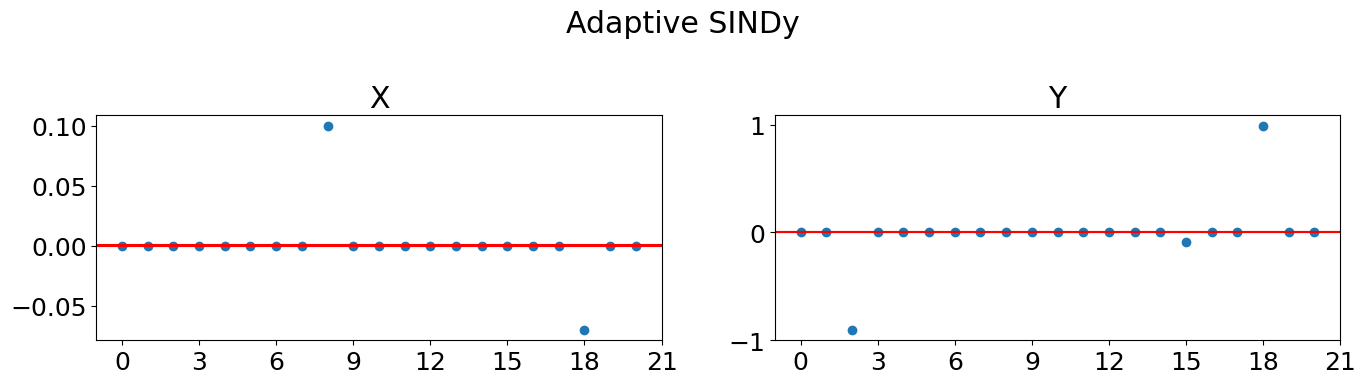

In [10]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o')
ax[0].set_title('X')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o')
ax[1].set_title('Y')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()


In [11]:
print(COEFF_ADT)
print(SINE_ADT )
print(XSINE_ADT)
print(COSINE_ADT)
print(XCOSINE_ADT)
print(EXP_ADT)
print(XEXP_ADT)


tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -0.9068],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.1000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -0.0922],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0700,  0.9917],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[0.0964, 3.2329],
        [0.0000, 0.4192]], device='cuda:0', requires

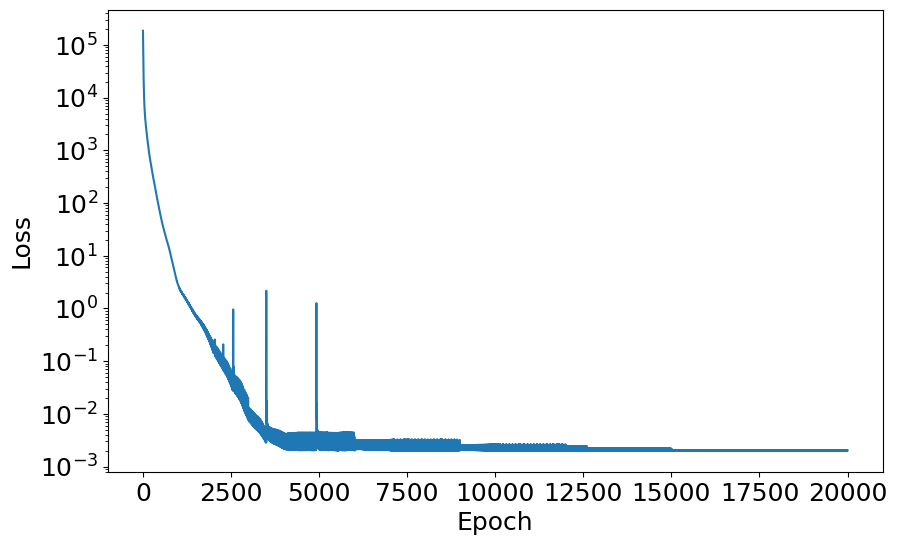

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(Loss_data.numpy())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(False)
plt.savefig('Loss_plot.jpeg', dpi = 1200)
plt.show()

In [13]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(21, N_modes, requires_grad= True, device= processor)

SINE_ADT    = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
COSINE_ADT  = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

XSINE_ADT   = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
XCOSINE_ADT = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

EXP_ADT     = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)
XEXP_ADT    = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, EXP_ADT, XEXP_ADT], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)


# WEIGHT FUNCTION OF SINDy MODEL
WEIGHTS  = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
nn.init.normal_(WEIGHTS, mean=0, std=1)
Lambda   = Parameter(torch.tensor(1.0), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda], maximize=False, lr = learning_rate*0.85, betas = (0.9,0.99),eps = 10**-15)


# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)

In [ ]:
# TEMPORAL MODE 1
A1_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0], EXP_ADT[:, 0], XSINE_ADT [:, 0], XCOSINE_ADT[:, 0], XEXP_ADT [:, 0]).to(processor)

# TEMPORAL MODE 2
A2_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1], EXP_ADT[:, 1], XSINE_ADT [:, 1], XCOSINE_ADT[:, 1], XEXP_ADT [:, 1]).to(processor)

Loss_data1     = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    A1_out, A2_out  = A1_DT (A_candidates), A2_DT (A_candidates)
    output_data  = torch.stack((A1_out , A2_out), dim = 1)
    loss_epoch   = loss_function (A1A2_time_deriv, output_data) + (1e-3 + torch.abs(Lambda))*torch.linalg.matrix_norm(COEFF_ADT, ord =1)
    
    optim_COEFF_ADT.zero_grad()
    optim_Lambda.zero_grad()
    optim_weights.zero_grad()
    loss_epoch.backward()

    with torch.no_grad():
        optim_COEFF_ADT.step()
        optim_Lambda.step()
        optim_weights.step()
        Loss_data1 [epoch] = loss_epoch.detach()
        
        COEFF_ADT   [torch.abs(COEFF_ADT)   <= tolerance] = 0.0
        SINE_ADT    [torch.abs(SINE_ADT)    <= tolerance] = 0.0
        COSINE_ADT  [torch.abs(COSINE_ADT)  <= tolerance] = 0.0
        XSINE_ADT   [torch.abs(XSINE_ADT)   <= tolerance] = 0.0
        XCOSINE_ADT [torch.abs(XCOSINE_ADT) <= tolerance] = 0.0
        EXP_ADT     [torch.abs(EXP_ADT)     <= tolerance] = 0.0
        XEXP_ADT    [torch.abs(XEXP_ADT)    <= tolerance] = 0.0
        
    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data1 [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)
       
    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()

In [15]:
print(COEFF_ADT)
print(SINE_ADT )
print(XSINE_ADT)
print(COSINE_ADT)
print(XCOSINE_ADT)
print(EXP_ADT)
print(XEXP_ADT)

tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -0.9166],
        [ 0.0000,  0.0000],
        [ 0.0506, -0.0153],
        [ 0.0000,  0.0000],
        [ 0.0767,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0260,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0199,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0249,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0736,  0.9440],
        [ 0.0315, -0.0870],
        [ 0.0000,  0.0000]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[0.2241, 2.5855],
        [0.4543, 0.3625]], device='cuda:0', requires

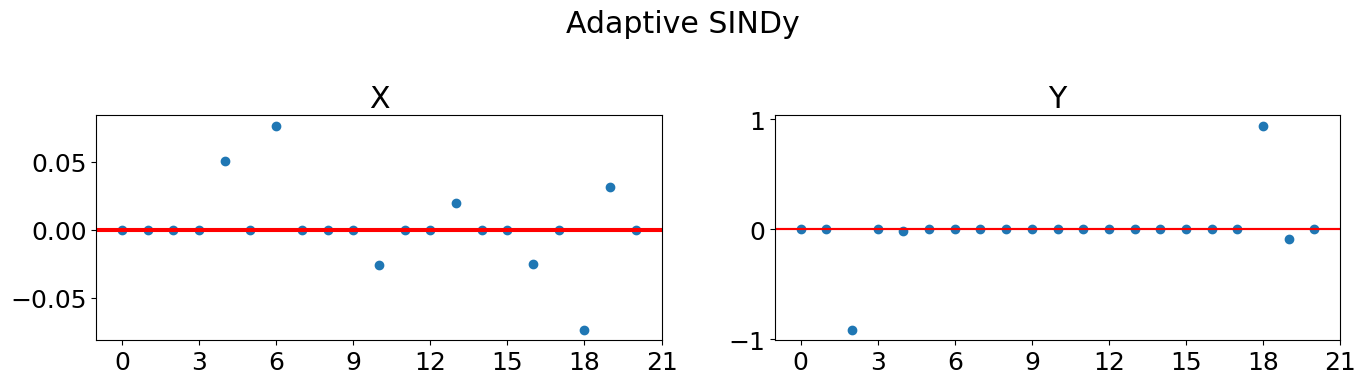

In [16]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o')
ax[0].set_title('X')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o')
ax[1].set_title('Y')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

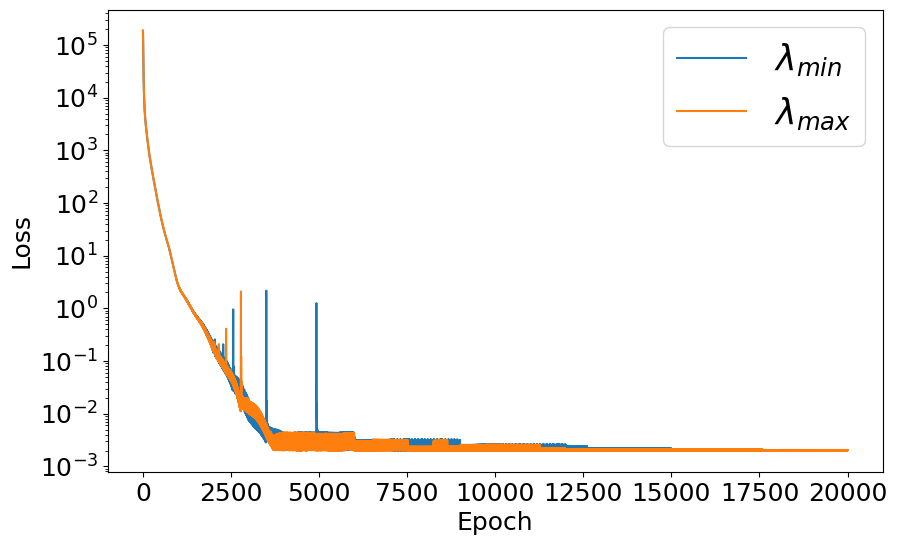

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(Loss_data.numpy(), label = "$\lambda_{min}$")
plt.plot(Loss_data1.numpy(),  label = "$\lambda_{max}$")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend(fontsize=25)
plt.grid(False)
plt.savefig('Loss_plot_1.jpeg', dpi = 1200)
plt.show()